### Benchmarking initiliazation, ops and cleanup time of the old dynamic ekey_history with static ekey_history and rocksdb
Insert, Update, Read ops
No of ops - 800,000
Distribution - Uniform.
System - Polaris compute debug node

Error in line :  273
RocksDB : 
{1: {'insert': {'init': 1.72905e-09, 'ops': 42.0878, 'cleanup': 0.0152699, 'total': 42.157}, 'update': {'init': 1.72905e-09, 'ops': 34.1535, 'cleanup': 0.0170097, 'total': 34.1705}, 'read': {'init': 1.72905e-09, 'ops': 21.2182, 'cleanup': 0.0136134, 'total': 21.2318}}, 2: {'insert': {'init': 1.72905e-09, 'ops': 22.4268, 'cleanup': 0.0129138, 'total': 22.6305}, 'update': {'init': 1.72905e-09, 'ops': 20.3529, 'cleanup': 0.0546527, 'total': 20.4075}, 'read': {'init': 1.72905e-09, 'ops': 12.9393, 'cleanup': 0.00899285, 'total': 12.9483}}, 4: {'insert': {'init': 1.72905e-09, 'ops': 11.5325, 'cleanup': 0.0103341, 'total': 11.749}, 'update': {'init': 1.72905e-09, 'ops': 12.1714, 'cleanup': 0.0443758, 'total': 12.2158}, 'read': {'init': 1.72905e-09, 'ops': 7.47903, 'cleanup': 0.0102976, 'total': 7.48933}}, 8: {'insert': {'init': 1.72905e-09, 'ops': 6.49128, 'cleanup': 0.0116633, 'total': 6.7195}, 'update': {'init': 1.72905e-09, 'ops': 8.00249, 'cleanup': 0.08378

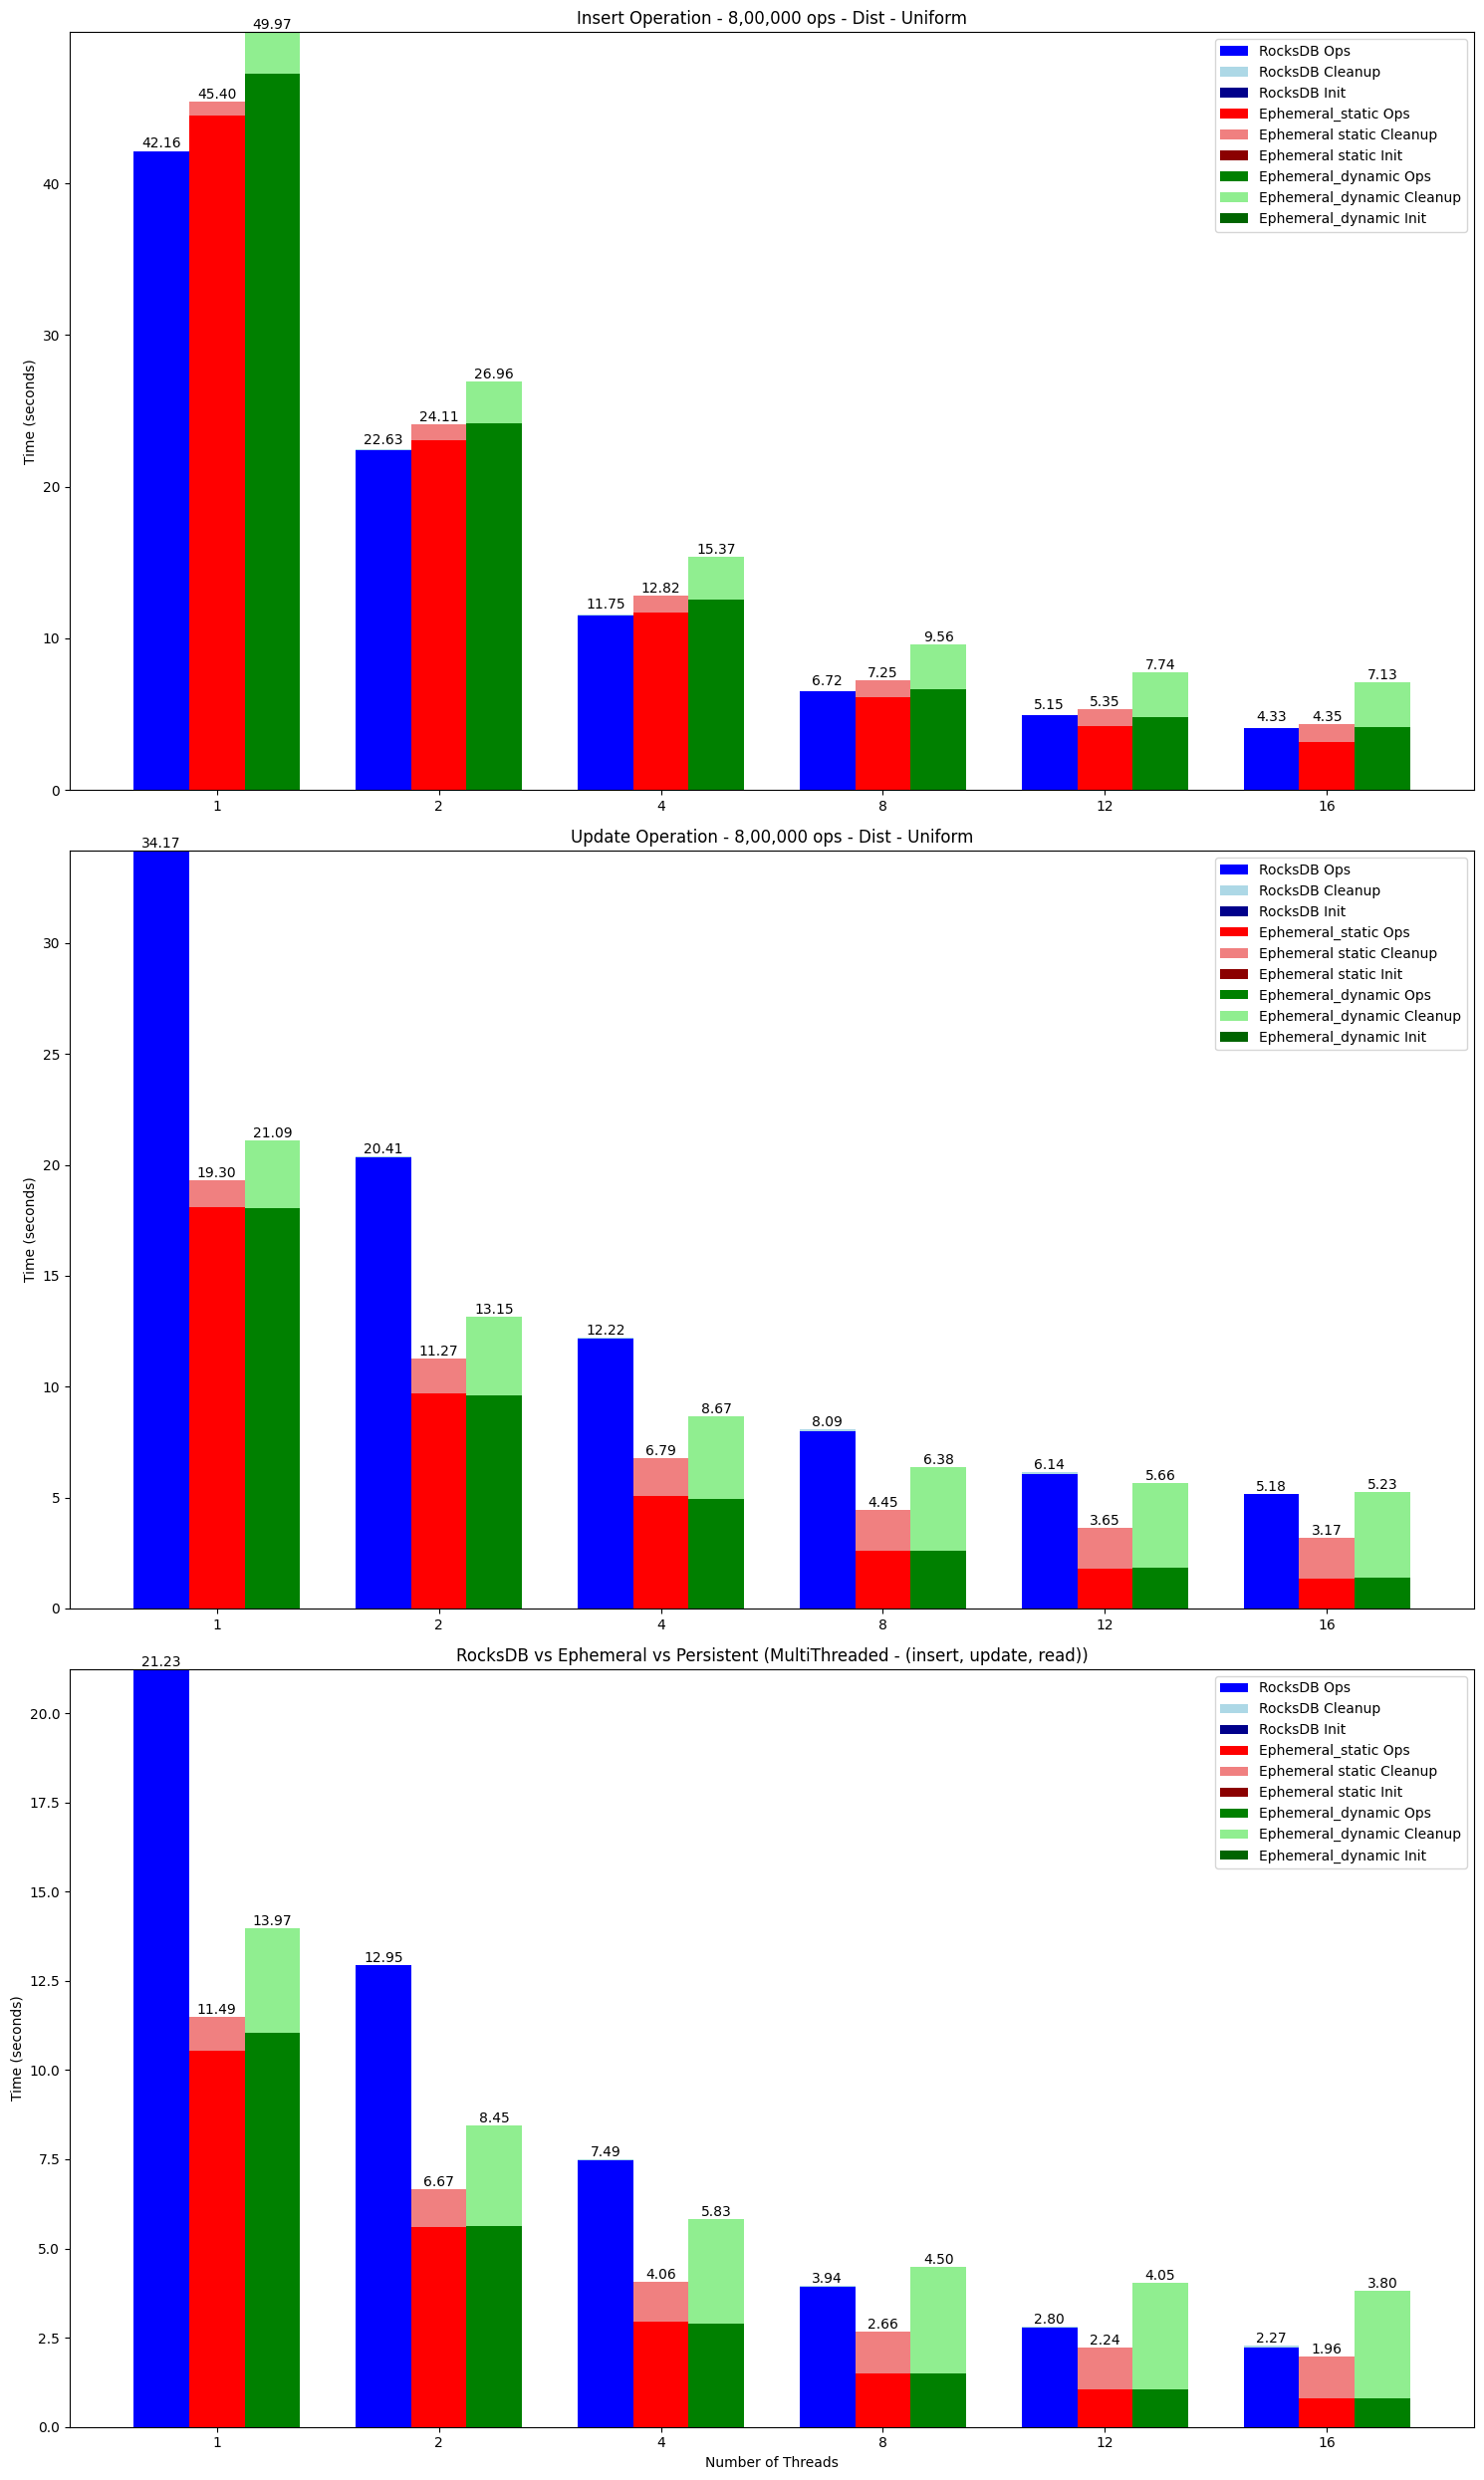

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {'insert': {}, 'update': {}, 'read': {}}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'

                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)

                    if match:
                        runtime_str = match.group(1)
                        converted_value = runtime_str.replace('e+', 'e-')
                        runtime_init = float(converted_value)
                        runtime_ops = float(match.group(2))
                        runtime_cleanup = float(match.group(3))
                        runtime_total = float(match.group(4))
                        data[current_thread][operation]['init'] = runtime_init
                        data[current_thread][operation]['ops'] = runtime_ops
                        data[current_thread][operation]['cleanup'] = runtime_cleanup
                        data[current_thread][operation]['total'] = runtime_total
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data):
    # def create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data):
    threads = sorted(set(rocksdb_data) | set(ephemeral_static_data.keys()) | set(ephemeral_dynamic_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.25
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    for i, operation in enumerate(operations):
        rocksdb_init = [rocksdb_data[t][operation].get('init', 0) for t in threads]
        rocksdb_ops = [rocksdb_data[t][operation].get('ops', 0) for t in threads]
        rocksdb_cleanup = [rocksdb_data[t][operation].get('cleanup', 0) for t in threads]
        rocksdb_total = [rocksdb_data[t][operation].get('total', 0) for t in threads]
        
        ephemeral_init = [ephemeral_static_data[t][operation].get('init', 0) for t in threads]
        ephemeral_ops = [ephemeral_static_data[t][operation].get('ops', 0) for t in threads]
        ephemeral_cleanup = [ephemeral_static_data[t][operation].get('cleanup', 0) for t in threads]
        ephemeral_total = [ephemeral_static_data[t][operation].get('total', 0) for t in threads]
        
        dynamic_init = [ephemeral_dynamic_data[t][operation].get('init', 0) for t in threads]
        dynamic_ops = [ephemeral_dynamic_data[t][operation].get('ops', 0) for t in threads]
        dynamic_cleanup = [ephemeral_dynamic_data[t][operation].get('cleanup', 0) for t in threads]
        dynamic_total = [ephemeral_dynamic_data[t][operation].get('total', 0) for t in threads]
        
        
        
        axs[i].bar(x - width, rocksdb_ops, width, label='RocksDB Ops', color='blue')
        axs[i].bar(x - width, rocksdb_cleanup, width, bottom=rocksdb_ops, label='RocksDB Cleanup', color='lightblue')
        axs[i].bar(x - width, rocksdb_init, width, bottom=[sum(x) for x in zip(rocksdb_ops, rocksdb_cleanup)], label='RocksDB Init', color='darkblue')
        
        axs[i].bar(x, ephemeral_ops, width, label='Ephemeral_static Ops', color='red')
        axs[i].bar(x, ephemeral_cleanup, width, bottom=ephemeral_ops, label='Ephemeral static Cleanup', color='lightcoral')
        axs[i].bar(x, ephemeral_init, width, bottom=[sum(x) for x in zip(ephemeral_ops, ephemeral_cleanup)], label='Ephemeral static Init', color='darkred')
        
        axs[i].bar(x + width, dynamic_ops, width, label='Ephemeral_dynamic Ops', color='green')
        axs[i].bar(x + width, dynamic_cleanup, width, bottom=dynamic_ops, label='Ephemeral_dynamic Cleanup', color='lightgreen')
        axs[i].bar(x + width, dynamic_init, width, bottom=[sum(x) for x in zip(dynamic_ops, dynamic_cleanup)], label='Ephemeral_dynamic Init', color='darkgreen')
        
        
        
        for j, thread in enumerate(threads):
            axs[i].text(x[j] - width, rocksdb_total[j], f'{rocksdb_total[j]:.2f}', ha='center', va='bottom')
            axs[i].text(x[j], ephemeral_total[j], f'{ephemeral_total[j]:.2f}', ha='center', va='bottom')
            axs[i].text(x[j] + width, dynamic_total[j], f'{dynamic_total[j]:.2f}', ha='center', va='bottom')
            
        
        axs[i].set_ylabel('Time (seconds)')
        axs[i].set_title(f'{operation.capitalize()} Operation - 8,00,000 ops - Dist - Uniform')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        axs[i].legend()
        # Set y-axis limit to 2e+6
        # axs[i].set_ylim(0, 2e+6)
    
    axs[2].set_xlabel('Number of Threads')
    plt.tight_layout()
    # plt.savefig('../plots/benchmark_results_static_dynamic_rocksdb_IUR.png')
    plt.title("RocksDB vs Ephemeral vs Persistent (MultiThreaded - (insert, update, read))")
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
# persistent_data = parse_file('../throughput_files/benchmark_ephemeral_dynamic_IRU.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_IRU.txt')
print("RocksDB : ")
print(rocksdb_data)
print("Ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic : ")
print(ephemeral_dynamic_data)

# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)
# create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data)


### Benchmarking throughput of the old dynamic ekey_history with static ekey_history and rocksdb
Insert, Update, Read ops
No of ops - 800,000
Distribution - Uniform.
System - Polaris compute debug node

Rocksdb : 
{1: {'insert': 19007.88351968979, 'read': 37703.48097388091, 'update': 23423.66082539125}, 2: {'insert': 35671.60718426169, 'read': 61827.14675446122, 'update': 39306.437903198064}, 4: {'insert': 69369.17407327119, 'read': 106965.7428837697, 'update': 65727.8538212531}, 8: {'insert': 123242.2573051848, 'read': 203245.31964137364, 'update': 99968.8846846419}, 12: {'insert': 162096.55686651144, 'read': 286551.42523515126, 'update': 131615.96435839686}, 16: {'insert': 197479.17828913915, 'read': 360586.1327587994, 'update': 155521.60000622086}}
ephemeral static : 
{1: {'insert': 17997.75028121485, 'update': 44254.8860160092, 'read': 75964.75235490732}, 2: {'insert': 34719.50976052218, 'update': 82357.31338090154, 'read': 142689.48271495278}, 4: {'insert': 68232.02299419175, 'update': 158370.05538992689, 'read': 271222.2971850516}, 8: {'insert': 131130.55850143998, 'update': 308376.6666795157, 'read': 536678.6301277966}, 12: {'insert': 190969.9842927188, 'update': 443796.0091643

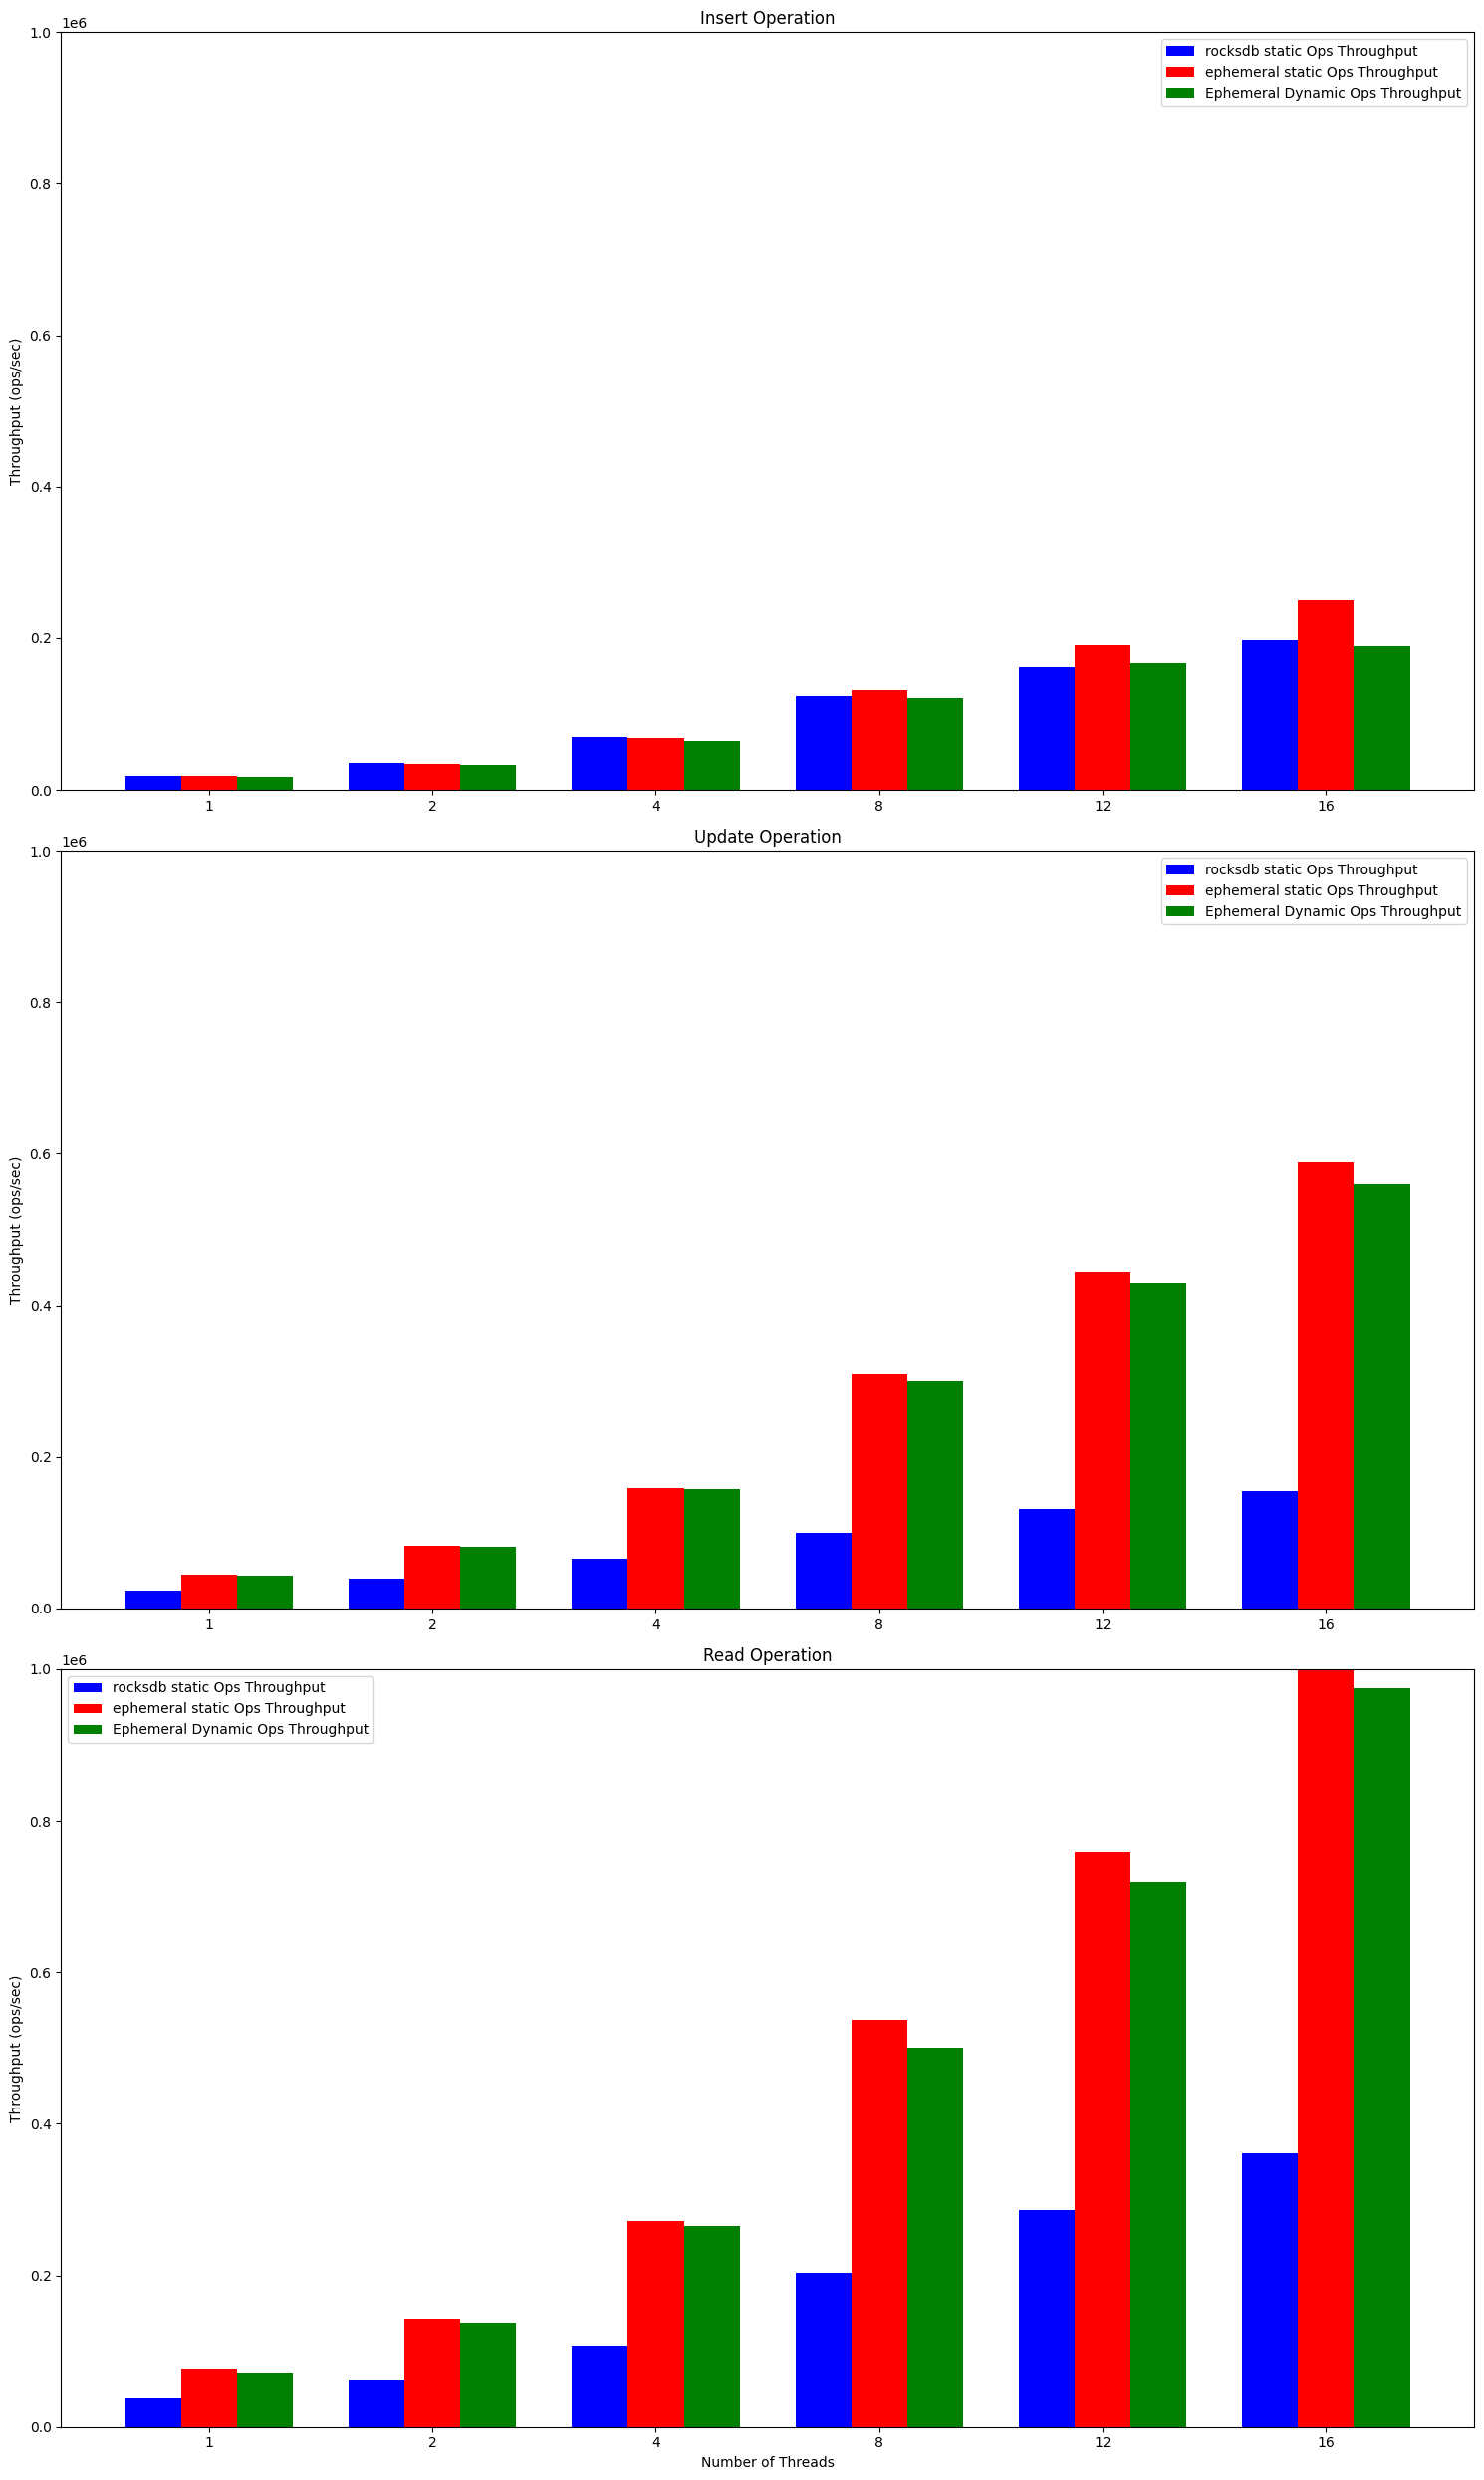

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                throughput = 0.0
                ops_time = 0.0
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'
                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)
                    if match:
                        ops_time = float(match.group(2))
                        data[current_thread][operation]= 800000 / ops_time
                    
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, rocksdb_dynamic_data):
    # def create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data):
    threads = sorted(set(rocksdb_data.keys()) | set(ephemeral_static_data.keys()) | set(ephemeral_static_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.25
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    for i, operation in enumerate(operations):

        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        ephemeral_static_throughput = [ephemeral_static_data[t].get(f'{operation}', 0) for t in threads]
        
        ephemeral_dynamic_throughput = [ephemeral_dynamic_data[t][operation] for t in threads]

        rocksdb_throughput = [rocksdb_data[t][operation] for t in threads]
        
        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        
        axs[i].bar(x - width, rocksdb_throughput, width, label='rocksdb static Ops Throughput', color='blue')
        # axs[i].bar(x - width, rocksdb_cleanup, width, bottom=rocksdb_ops, label='RocksDB Cleanup', color='lightblue')
        # axs[i].bar(x - width, rocksdb_init, width, bottom=[sum(x) for x in zip(rocksdb_ops, rocksdb_cleanup)], label='RocksDB Init', color='darkblue')
        
        axs[i].bar(x, ephemeral_static_throughput, width, label='ephemeral static Ops Throughput', color='red')


        axs[i].bar(x + width, ephemeral_dynamic_throughput, width, label='Ephemeral Dynamic Ops Throughput', color='green')
        # axs[i].bar(x, persistent_cleanup, width, bottom=persistent_ops, label='Persistent Cleanup', color='lightgreen')
        # axs[i].bar(x, persistent_init, width, bottom=[sum(x) for x in zip(persistent_ops, persistent_cleanup)], label='Persistent Init', color='darkgreen')
        
        
        
        # axs[i].bar(x + width, ephemeral_throughput, width, label='Ephemeral Ops Throughput', color='red')
        # axs[i].bar(x + width, ephemeral_cleanup, width, bottom=ephemeral_ops, label='Ephemeral Cleanup', color='lightcoral')
        # axs[i].bar(x + width, ephemeral_init, width, bottom=[sum(x) for x in zip(ephemeral_ops, ephemeral_cleanup)], label='Ephemeral Init', color='darkred')
        
        # for j, thread in enumerate(threads):
        #     axs[i].text(x[j] - width, rocksdb_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j], persistent_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j] + width, ephemeral_throughput[j], ha='center', va='bottom')
        
        axs[i].set_ylabel('Throughput (ops/sec)')
        axs[i].set_title(f'{operation.capitalize()} Operation')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        axs[i].legend()
        # Set y-axis limit to 2e+6
        axs[i].set_ylim(0, 1e+6)
    
    axs[2].set_xlabel('Number of Threads')
    plt.tight_layout()
    # plt.savefig('../plots/benchmark_results_throughput_static_dynamic_prev_rocksdb_IUR.png')
    # plt.title("RocksDB vs Ephemeral vs Persistent (MultiThreaded - (insert, update, read))")
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_prev_IRU.txt')
# ephemeral_data = parse_file('benchmark_ephemeral.txt')
# print("RocksDB : ")
# print(rocksdb_data)
# print("Persistent : ")
# print(persistent_data)
print("Rocksdb : ")
print(rocksdb_data)
print("ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic: ")
print(ephemeral_dynamic_data)


# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)


### Benchmarking throughput of the new dynamic ekey_history with static ekey_history and rocksdb
Insert, Update, Read ops
No of ops - 800,000
Distribution - Uniform.
System - Polaris compute debug node

Rocksdb : 
{1: {'insert': 19007.88351968979, 'read': 37703.48097388091, 'update': 23423.66082539125}, 2: {'insert': 35671.60718426169, 'read': 61827.14675446122, 'update': 39306.437903198064}, 4: {'insert': 69369.17407327119, 'read': 106965.7428837697, 'update': 65727.8538212531}, 8: {'insert': 123242.2573051848, 'read': 203245.31964137364, 'update': 99968.8846846419}, 12: {'insert': 162096.55686651144, 'read': 286551.42523515126, 'update': 131615.96435839686}, 16: {'insert': 197479.17828913915, 'read': 360586.1327587994, 'update': 155521.60000622086}}
ephemeral static : 
{1: {'insert': 17997.75028121485, 'update': 44254.8860160092, 'read': 75964.75235490732}, 2: {'insert': 34719.50976052218, 'update': 82357.31338090154, 'read': 142689.48271495278}, 4: {'insert': 68232.02299419175, 'update': 158370.05538992689, 'read': 271222.2971850516}, 8: {'insert': 131130.55850143998, 'update': 308376.6666795157, 'read': 536678.6301277966}, 12: {'insert': 190969.9842927188, 'update': 443796.0091643

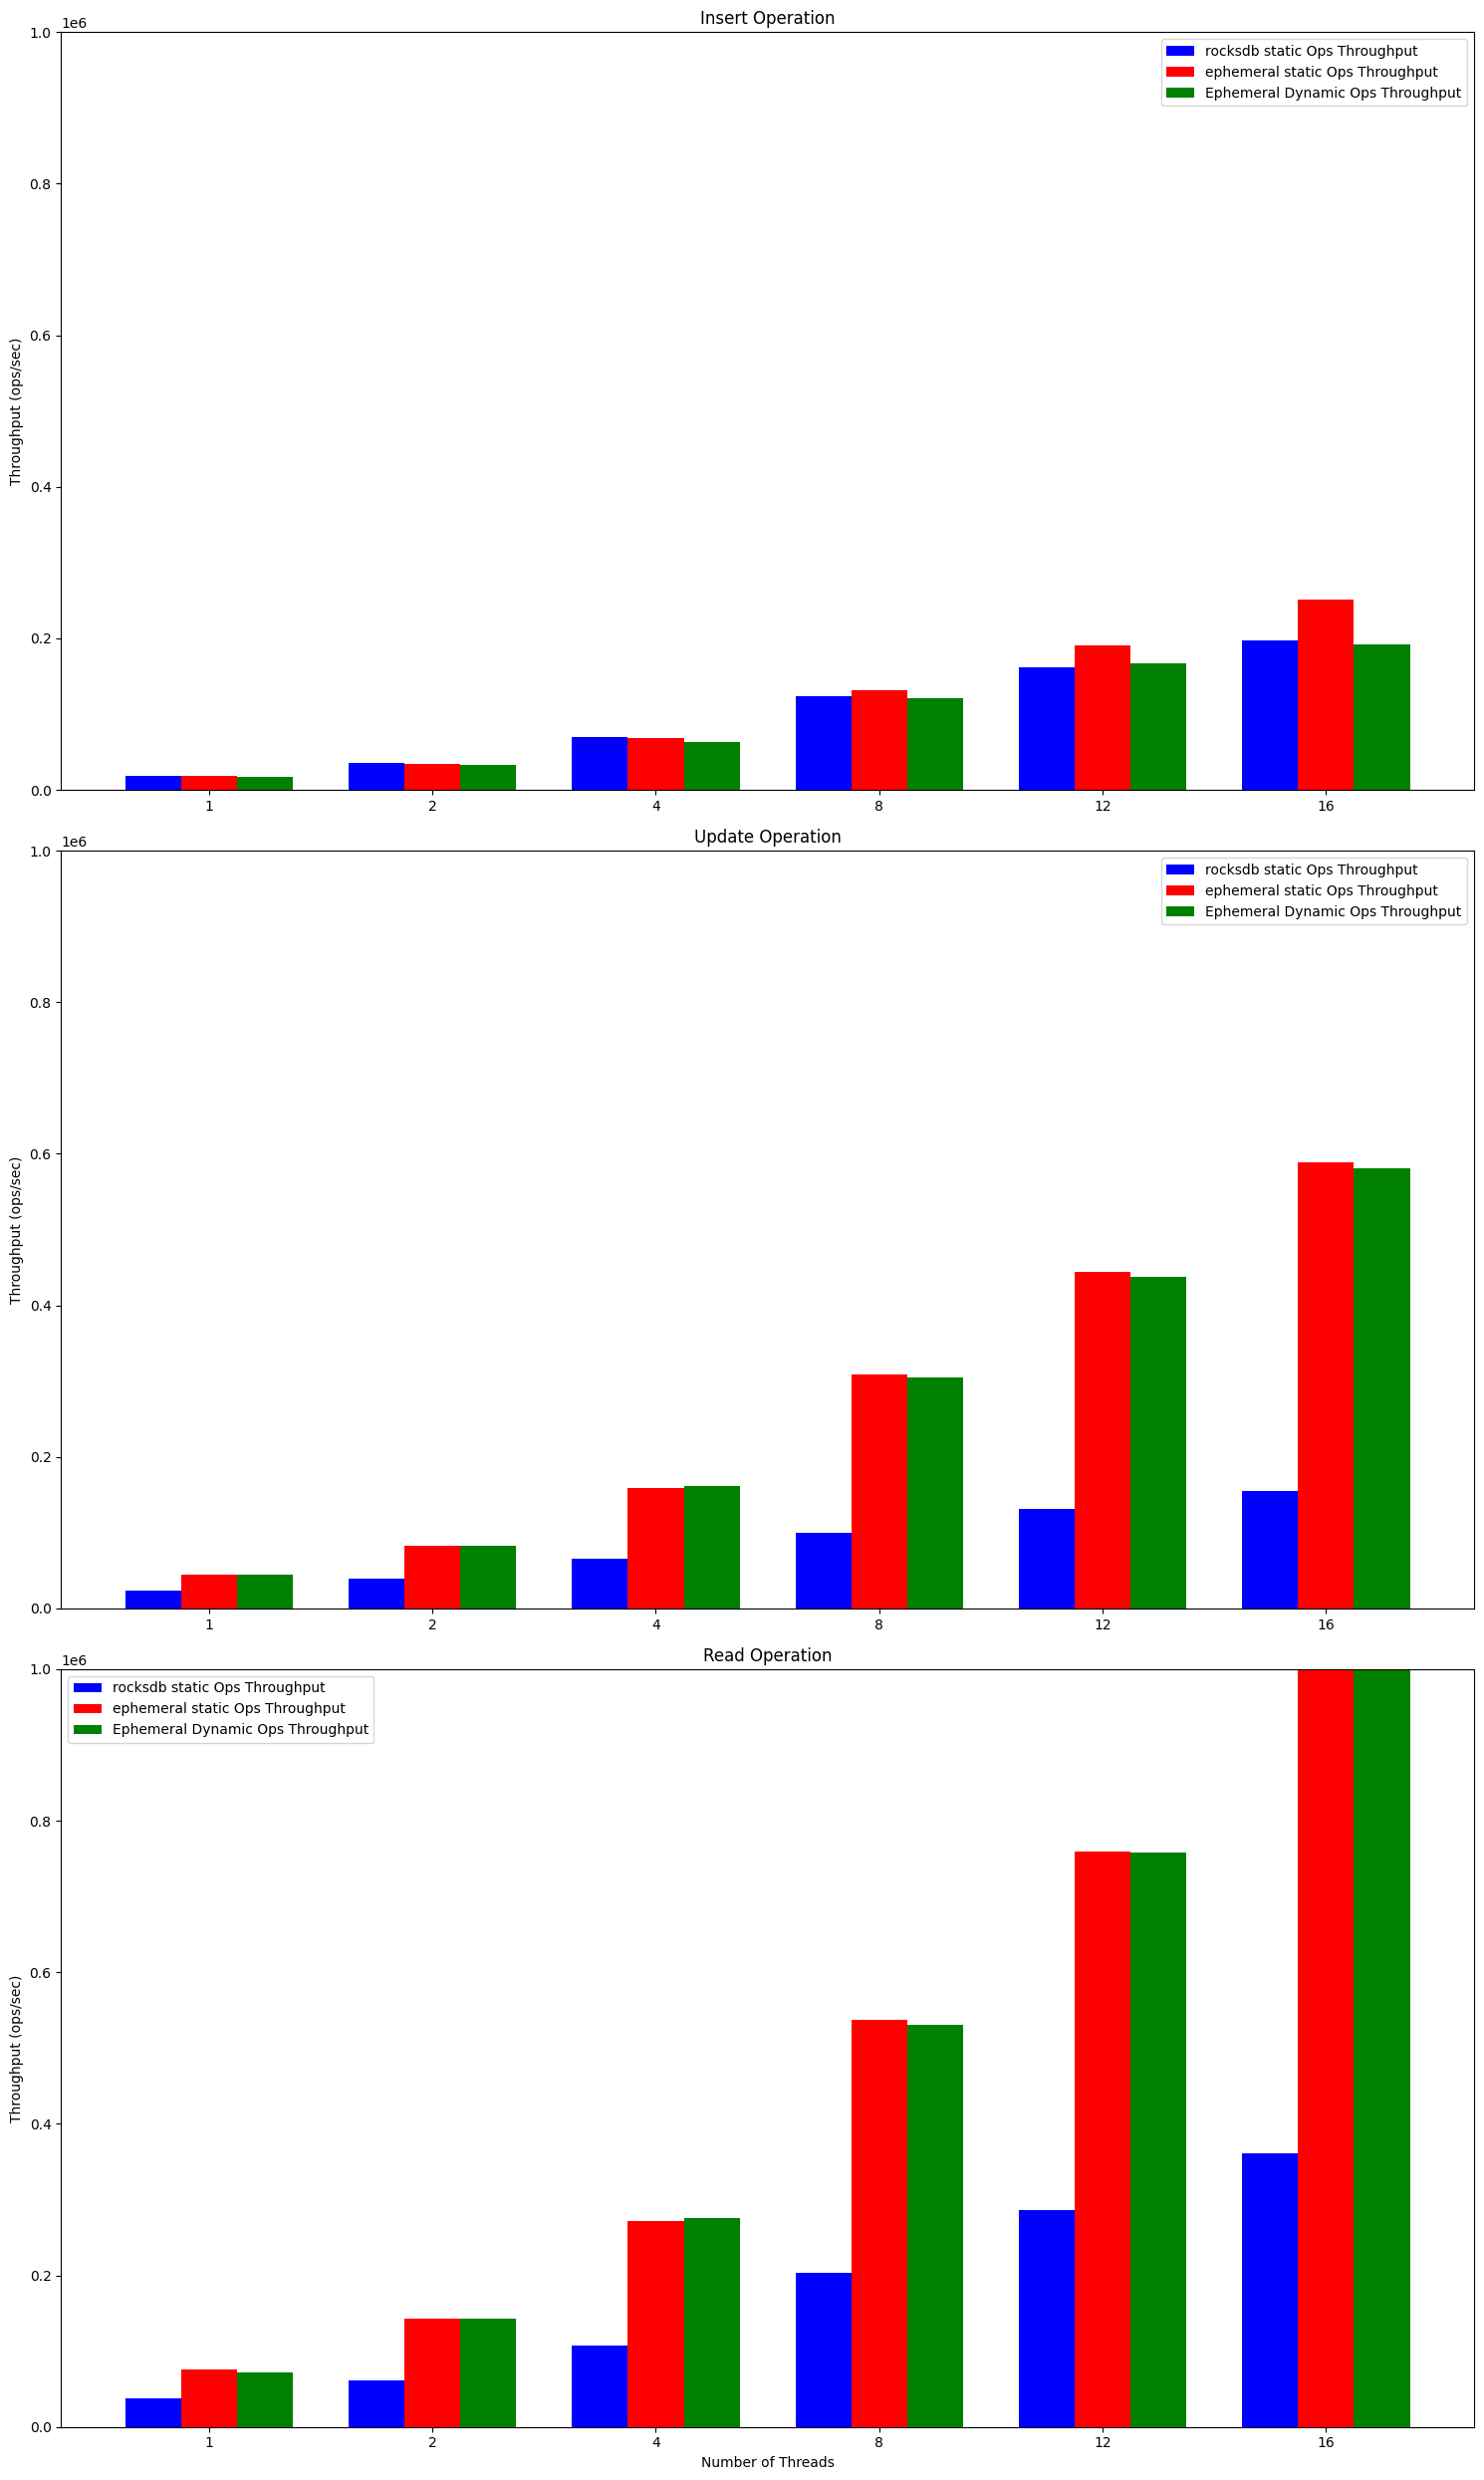

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                throughput = 0.0
                ops_time = 0.0
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'
                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)
                    if match:
                        ops_time = float(match.group(2))
                        data[current_thread][operation]= 800000 / ops_time
                    
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, rocksdb_dynamic_data):
    # def create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data):
    threads = sorted(set(rocksdb_data.keys()) | set(ephemeral_static_data.keys()) | set(ephemeral_static_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.25
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    for i, operation in enumerate(operations):

        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        ephemeral_static_throughput = [ephemeral_static_data[t].get(f'{operation}', 0) for t in threads]
        
        ephemeral_dynamic_throughput = [ephemeral_dynamic_data[t][operation] for t in threads]

        rocksdb_throughput = [rocksdb_data[t][operation] for t in threads]
        
        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        
        axs[i].bar(x - width, rocksdb_throughput, width, label='rocksdb static Ops Throughput', color='blue')
        # axs[i].bar(x - width, rocksdb_cleanup, width, bottom=rocksdb_ops, label='RocksDB Cleanup', color='lightblue')
        # axs[i].bar(x - width, rocksdb_init, width, bottom=[sum(x) for x in zip(rocksdb_ops, rocksdb_cleanup)], label='RocksDB Init', color='darkblue')
        
        axs[i].bar(x, ephemeral_static_throughput, width, label='ephemeral static Ops Throughput', color='red')


        axs[i].bar(x + width, ephemeral_dynamic_throughput, width, label='Ephemeral Dynamic Ops Throughput', color='green')
        # axs[i].bar(x, persistent_cleanup, width, bottom=persistent_ops, label='Persistent Cleanup', color='lightgreen')
        # axs[i].bar(x, persistent_init, width, bottom=[sum(x) for x in zip(persistent_ops, persistent_cleanup)], label='Persistent Init', color='darkgreen')
        
        
        
        # axs[i].bar(x + width, ephemeral_throughput, width, label='Ephemeral Ops Throughput', color='red')
        # axs[i].bar(x + width, ephemeral_cleanup, width, bottom=ephemeral_ops, label='Ephemeral Cleanup', color='lightcoral')
        # axs[i].bar(x + width, ephemeral_init, width, bottom=[sum(x) for x in zip(ephemeral_ops, ephemeral_cleanup)], label='Ephemeral Init', color='darkred')
        
        # for j, thread in enumerate(threads):
        #     axs[i].text(x[j] - width, rocksdb_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j], persistent_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j] + width, ephemeral_throughput[j], ha='center', va='bottom')
        
        axs[i].set_ylabel('Throughput (ops/sec)')
        axs[i].set_title(f'{operation.capitalize()} Operation')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        axs[i].legend()
        # Set y-axis limit to 2e+6
        axs[i].set_ylim(0, 1e+6)
    
    axs[2].set_xlabel('Number of Threads')
    plt.tight_layout()
    # plt.savefig('../plots/benchmark_results_throughput_static_dynamic_prev_rocksdb_IUR.png')
    # plt.title("RocksDB vs Ephemeral vs Persistent (MultiThreaded - (insert, update, read))")
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_IRU.txt')
# ephemeral_data = parse_file('benchmark_ephemeral.txt')
# print("RocksDB : ")
# print(rocksdb_data)
# print("Persistent : ")
# print(persistent_data)
print("Rocksdb : ")
print(rocksdb_data)
print("ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic: ")
print(ephemeral_dynamic_data)


# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)


### Benchmarking times of ops, initialization and cleanup of the new dynamic ekey_history (with tail implementation) with static ekey_history and rocksdb
Insert, Update, Read ops
No of ops - 800,000
Distribution - Uniform.
System - Polaris compute debug node
Block_Size = 128

Error in line :  273
RocksDB : 
{1: {'insert': {'init': 1.72905e-09, 'ops': 42.0878, 'cleanup': 0.0152699, 'total': 42.157}, 'update': {'init': 1.72905e-09, 'ops': 34.1535, 'cleanup': 0.0170097, 'total': 34.1705}, 'read': {'init': 1.72905e-09, 'ops': 21.2182, 'cleanup': 0.0136134, 'total': 21.2318}}, 2: {'insert': {'init': 1.72905e-09, 'ops': 22.4268, 'cleanup': 0.0129138, 'total': 22.6305}, 'update': {'init': 1.72905e-09, 'ops': 20.3529, 'cleanup': 0.0546527, 'total': 20.4075}, 'read': {'init': 1.72905e-09, 'ops': 12.9393, 'cleanup': 0.00899285, 'total': 12.9483}}, 4: {'insert': {'init': 1.72905e-09, 'ops': 11.5325, 'cleanup': 0.0103341, 'total': 11.749}, 'update': {'init': 1.72905e-09, 'ops': 12.1714, 'cleanup': 0.0443758, 'total': 12.2158}, 'read': {'init': 1.72905e-09, 'ops': 7.47903, 'cleanup': 0.0102976, 'total': 7.48933}}, 8: {'insert': {'init': 1.72905e-09, 'ops': 6.49128, 'cleanup': 0.0116633, 'total': 6.7195}, 'update': {'init': 1.72905e-09, 'ops': 8.00249, 'cleanup': 0.08378

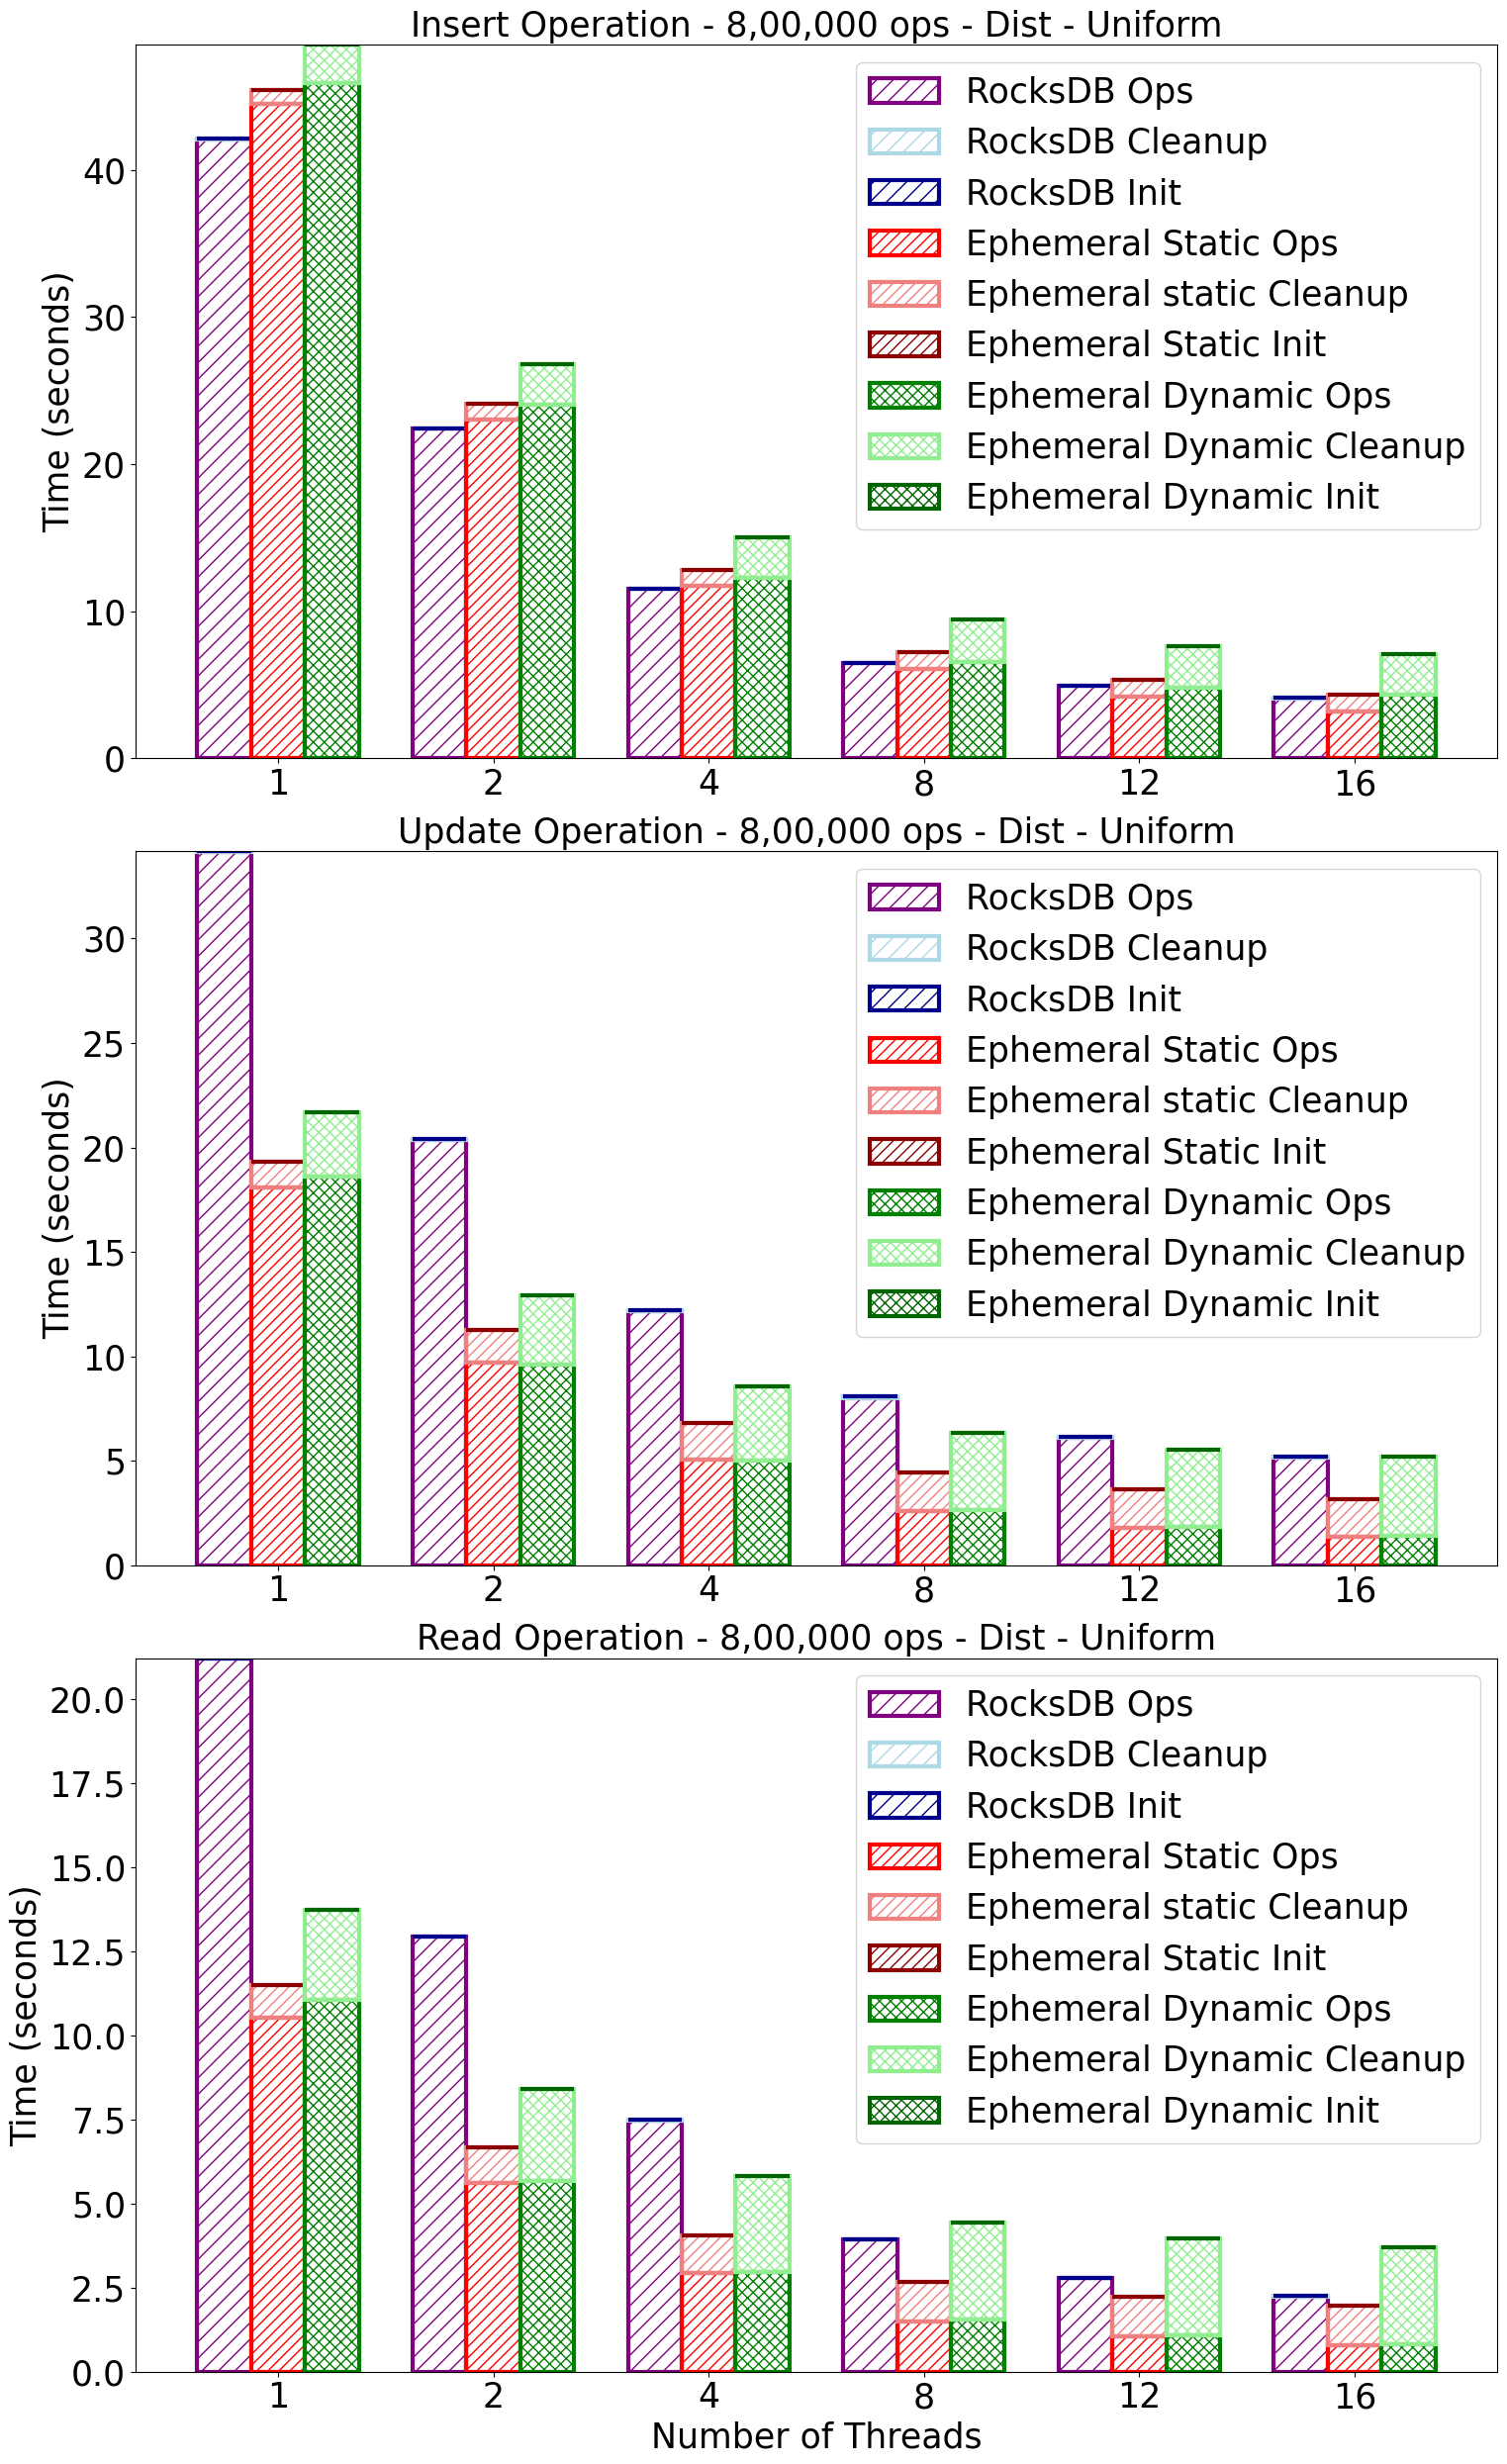

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {'insert': {}, 'update': {}, 'read': {}}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'

                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)

                    if match:
                        runtime_str = match.group(1)
                        converted_value = runtime_str.replace('e+', 'e-')
                        runtime_init = float(converted_value)
                        runtime_ops = float(match.group(2))
                        runtime_cleanup = float(match.group(3))
                        runtime_total = float(match.group(4))
                        data[current_thread][operation]['init'] = runtime_init
                        data[current_thread][operation]['ops'] = runtime_ops
                        data[current_thread][operation]['cleanup'] = runtime_cleanup
                        data[current_thread][operation]['total'] = runtime_total
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data):
    threads = sorted(set(rocksdb_data) | set(ephemeral_static_data.keys()) | set(ephemeral_dynamic_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.25
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    # Increase border width and hatch density
    border_width = 3.0
    dense_hatch = '//'  # Triple slash for denser pattern
    
    for i, operation in enumerate(operations):
        rocksdb_init = [rocksdb_data[t][operation].get('init', 0) for t in threads]
        rocksdb_ops = [rocksdb_data[t][operation].get('ops', 0) for t in threads]
        rocksdb_cleanup = [rocksdb_data[t][operation].get('cleanup', 0) for t in threads]
        
        ephemeral_init = [ephemeral_static_data[t][operation].get('init', 0) for t in threads]
        ephemeral_ops = [ephemeral_static_data[t][operation].get('ops', 0) for t in threads]
        ephemeral_cleanup = [ephemeral_static_data[t][operation].get('cleanup', 0) for t in threads]
        
        dynamic_init = [ephemeral_dynamic_data[t][operation].get('init', 0) for t in threads]
        dynamic_ops = [ephemeral_dynamic_data[t][operation].get('ops', 0) for t in threads]
        dynamic_cleanup = [ephemeral_dynamic_data[t][operation].get('cleanup', 0) for t in threads]
        
        # RocksDB bars with thicker borders and denser hatching
        axs[i].bar(x - width, rocksdb_ops, width, label='RocksDB Ops', 
                  hatch=dense_hatch, facecolor='none', edgecolor='purple', linewidth=border_width)
        axs[i].bar(x - width, rocksdb_cleanup, width, bottom=rocksdb_ops, 
                  label='RocksDB Cleanup', hatch=dense_hatch, facecolor='none', 
                  edgecolor='lightblue', linewidth=border_width)
        axs[i].bar(x - width, rocksdb_init, width, 
                  bottom=[sum(x) for x in zip(rocksdb_ops, rocksdb_cleanup)], 
                  label='RocksDB Init', hatch=dense_hatch, facecolor='none', 
                  edgecolor='darkblue', linewidth=border_width)
        
        # Ephemeral Static bars
        axs[i].bar(x, ephemeral_ops, width, label='Ephemeral Static Ops', 
                  hatch='///', facecolor='none', edgecolor='red', linewidth=border_width)
        axs[i].bar(x, ephemeral_cleanup, width, bottom=ephemeral_ops, 
                  label='Ephemeral static Cleanup', hatch='///', facecolor='none', 
                  edgecolor='lightcoral', linewidth=border_width)
        axs[i].bar(x, ephemeral_init, width, 
                  bottom=[sum(x) for x in zip(ephemeral_ops, ephemeral_cleanup)], 
                  label='Ephemeral Static Init', hatch='///', facecolor='none', 
                  edgecolor='darkred', linewidth=border_width)
        
        # Dynamic bars
        axs[i].bar(x + width, dynamic_ops, width, label='Ephemeral Dynamic Ops', 
                  hatch='xxx', facecolor='none', edgecolor='green', linewidth=border_width)
        axs[i].bar(x + width, dynamic_cleanup, width, bottom=dynamic_ops, 
                  label='Ephemeral Dynamic Cleanup', hatch='xxx', facecolor='none', 
                  edgecolor='lightgreen', linewidth=border_width)
        axs[i].bar(x + width, dynamic_init, width, 
                  bottom=[sum(x) for x in zip(dynamic_ops, dynamic_cleanup)], 
                  label='Ephemeral Dynamic Init', hatch='xxx', facecolor='none', 
                  edgecolor='darkgreen', linewidth=border_width)
        
        axs[i].set_ylabel('Time (seconds)', fontsize=25)
        axs[i].set_title(f'{operation.capitalize()} Operation - 8,00,000 ops - Dist - Uniform', fontsize=25)
        axs[i].set_xticks(x)
        axs[i].tick_params(axis='x', labelsize=25)
        axs[i].tick_params(axis='y', labelsize=25)
        axs[i].set_xticklabels(threads)
        axs[i].legend(fontsize=25, loc='upper right')
    
    axs[2].set_xlabel('Number of Threads', fontsize=25)
    plt.tight_layout()
    # plt.title("RocksDB vs Ephemeral vs Persistent (MultiThreaded - (insert, update, read))", fontsize=20)
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
# persistent_data = parse_file('../throughput_files/benchmark_ephemeral_dynamic_IRU.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_tail_IRU.txt')
print("RocksDB : ")
print(rocksdb_data)
print("Ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic : ")
print(ephemeral_dynamic_data)

# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)
# create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data)



### Benchmarking throughput of the new dynamic ekey_history (lazy tail implementation) with static ekey_history and rocksdb
Insert, Update, Read ops
No of ops - 800,000
Distribution - Uniform.
System - Polaris compute debug node
Block_Size = 128

Rocksdb : 
{1: {'insert': 19007.88351968979, 'read': 37703.48097388091, 'update': 23423.66082539125}, 2: {'insert': 35671.60718426169, 'read': 61827.14675446122, 'update': 39306.437903198064}, 4: {'insert': 69369.17407327119, 'read': 106965.7428837697, 'update': 65727.8538212531}, 8: {'insert': 123242.2573051848, 'read': 203245.31964137364, 'update': 99968.8846846419}, 12: {'insert': 162096.55686651144, 'read': 286551.42523515126, 'update': 131615.96435839686}, 16: {'insert': 197479.17828913915, 'read': 360586.1327587994, 'update': 155521.60000622086}}
ephemeral static : 
{1: {'insert': 17997.75028121485, 'update': 44254.8860160092, 'read': 75964.75235490732}, 2: {'insert': 34719.50976052218, 'update': 82357.31338090154, 'read': 142689.48271495278}, 4: {'insert': 68232.02299419175, 'update': 158370.05538992689, 'read': 271222.2971850516}, 8: {'insert': 131130.55850143998, 'update': 308376.6666795157, 'read': 536678.6301277966}, 12: {'insert': 190969.9842927188, 'update': 443796.0091643

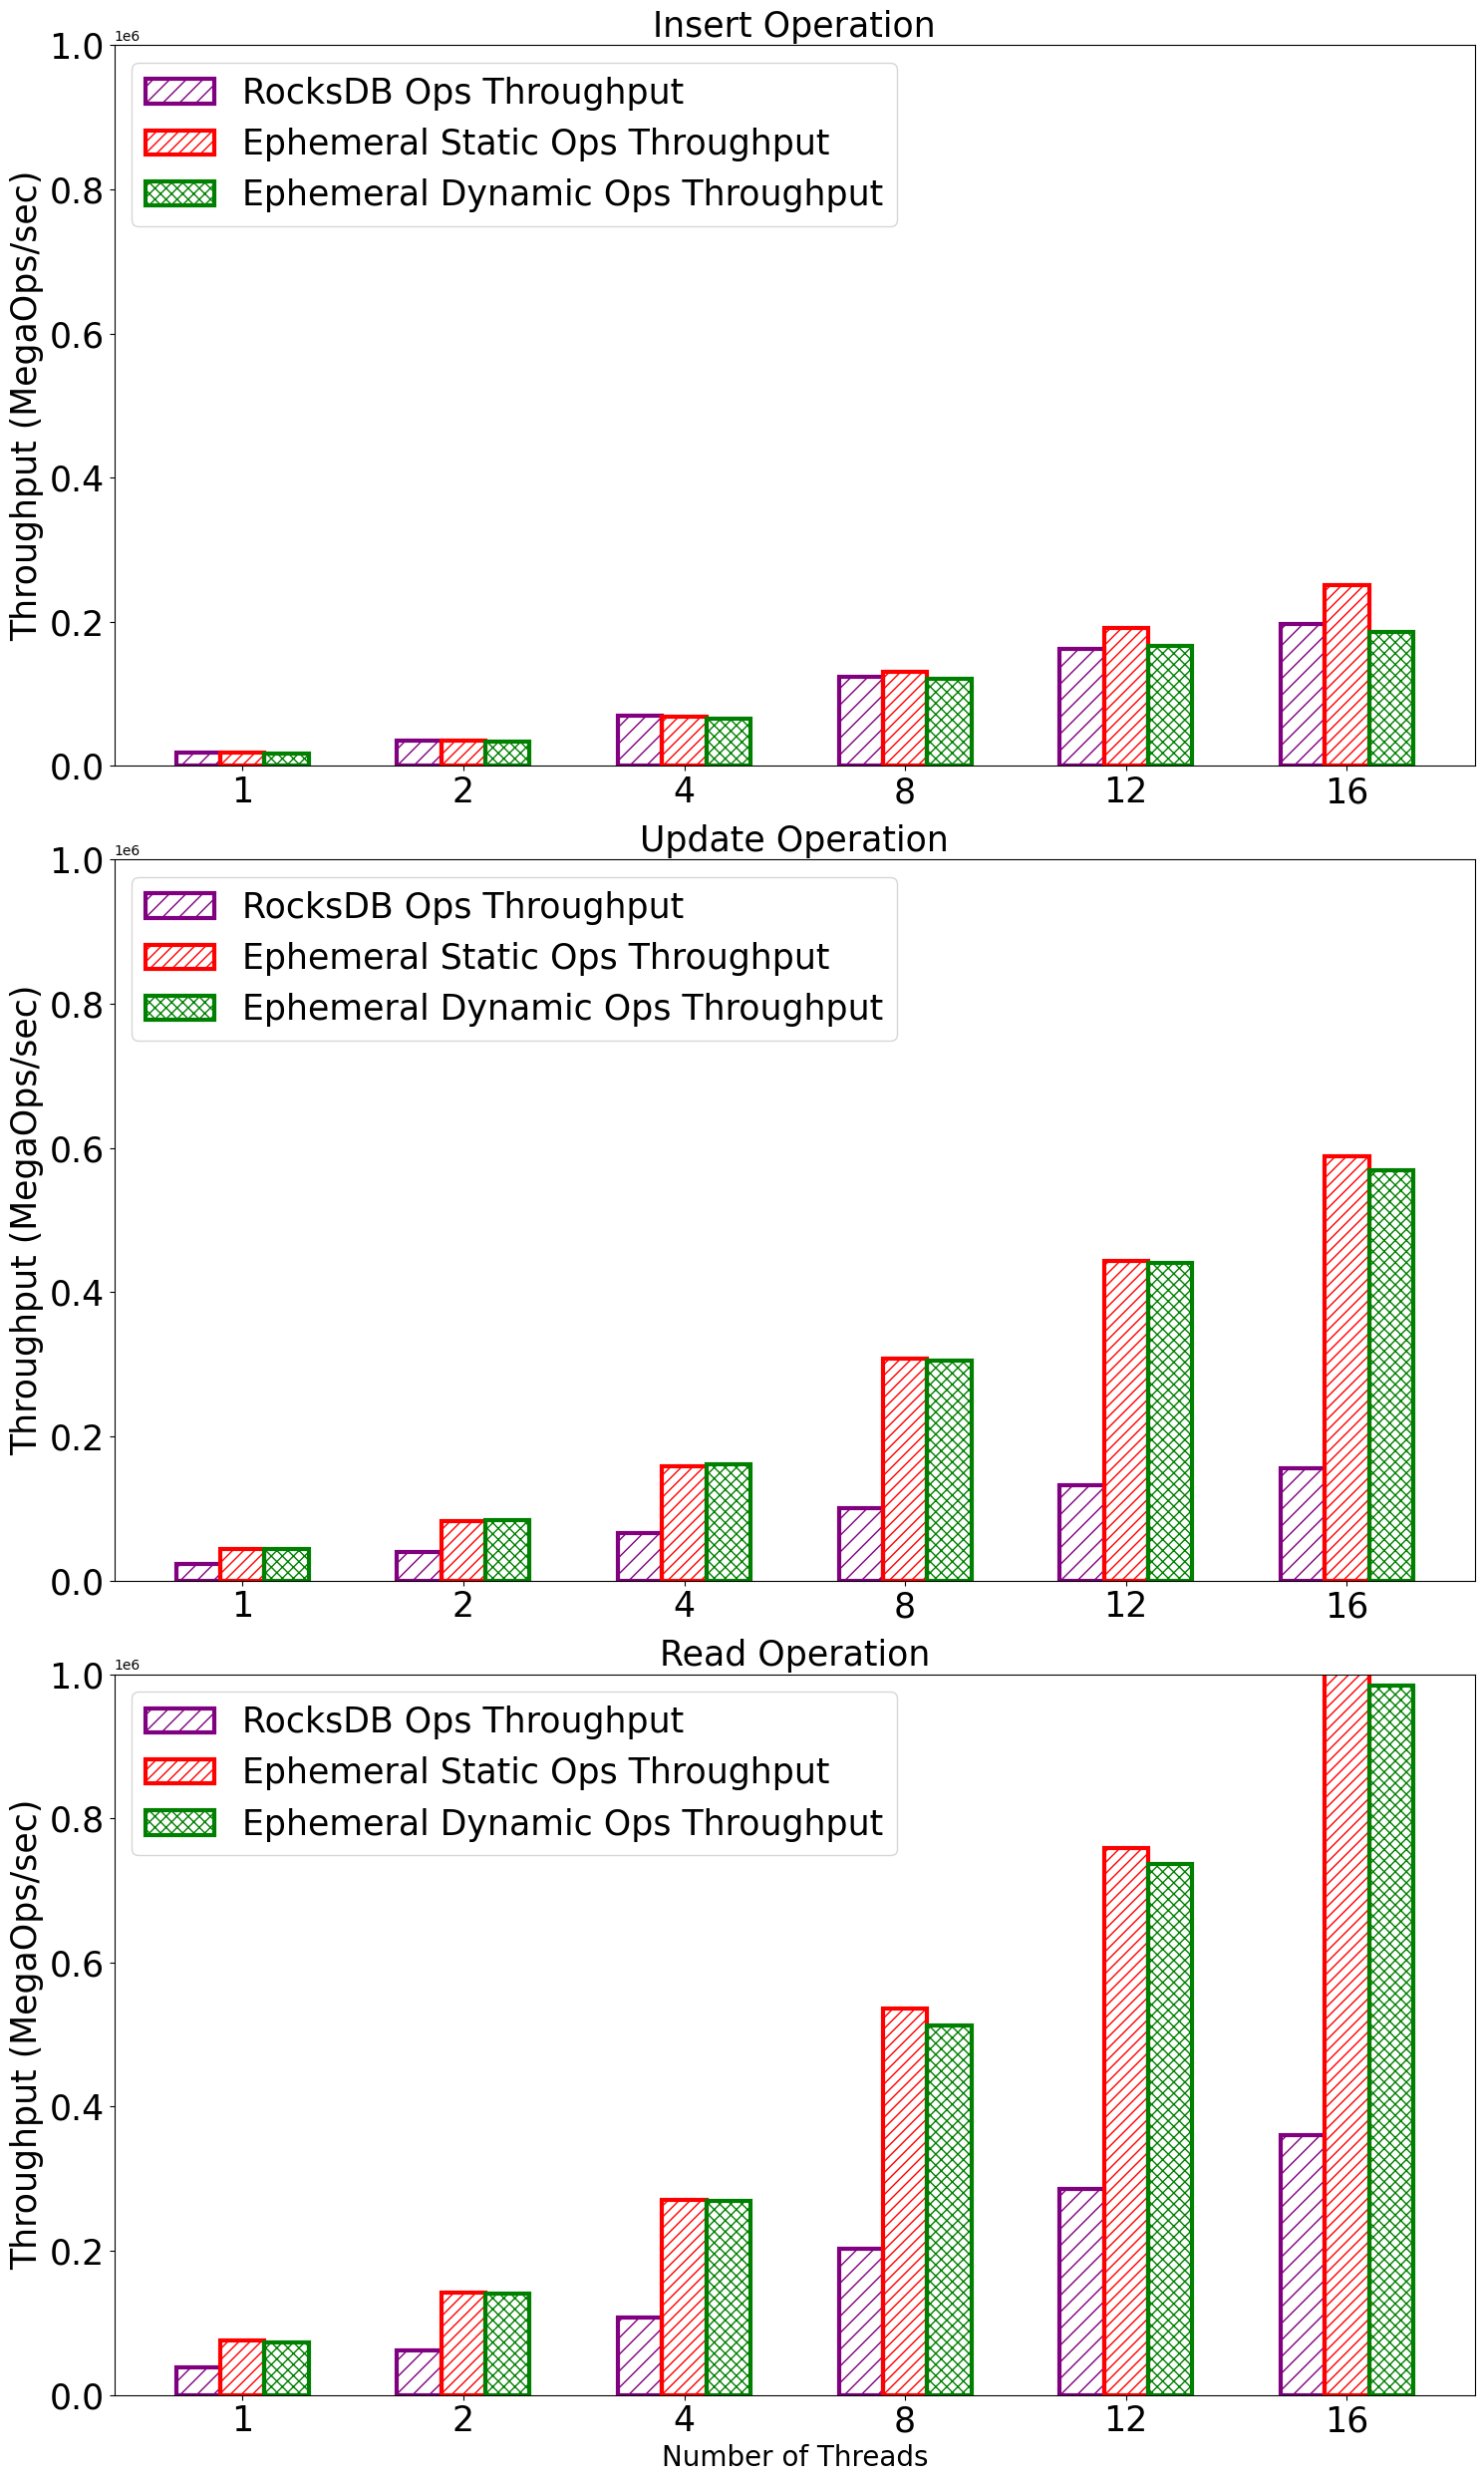

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                throughput = 0.0
                ops_time = 0.0
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'
                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)
                    if match:
                        ops_time = float(match.group(2))
                        data[current_thread][operation]= 800000 / ops_time
                    
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data):
    threads = sorted(set(rocksdb_data.keys()) | set(ephemeral_static_data.keys()) | set(ephemeral_dynamic_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.2
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    # Define style parameters
    border_width = 3.0
    dense_hatch = '//'
    
    for i, operation in enumerate(operations):
        ephemeral_static_throughput = [ephemeral_static_data[t].get(f'{operation}', 0) for t in threads]
        ephemeral_dynamic_throughput = [ephemeral_dynamic_data[t][operation] for t in threads]
        rocksdb_throughput = [rocksdb_data[t][operation] for t in threads]
        
        # RocksDB bars
        axs[i].bar(x - width, rocksdb_throughput, width, 
                  label='RocksDB Ops Throughput', 
                  hatch=dense_hatch, 
                  facecolor='none', 
                  edgecolor='purple', 
                  linewidth=border_width)
        
        # Ephemeral Static bars
        axs[i].bar(x, ephemeral_static_throughput, width, 
                  label='Ephemeral Static Ops Throughput', 
                  hatch='///', 
                  facecolor='none', 
                  edgecolor='red', 
                  linewidth=border_width)
        
        # Ephemeral Dynamic bars
        axs[i].bar(x + width, ephemeral_dynamic_throughput, width, 
                  label='Ephemeral Dynamic Ops Throughput', 
                  hatch='xxx', 
                  facecolor='none', 
                  edgecolor='green', 
                  linewidth=border_width)
        
        axs[i].set_ylabel('Throughput (MegaOps/sec)', fontsize=25)
        axs[i].set_title(f'{operation.capitalize()} Operation', fontsize=25)
        axs[i].tick_params(axis='x', labelsize=25)
        axs[i].tick_params(axis='y', labelsize=25)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        axs[i].legend(fontsize=25, loc='upper left')
        axs[i].set_ylim(0, 1e+6)
    
    axs[2].set_xlabel('Number of Threads', fontsize=20)
    plt.tight_layout()
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_tail_IRU.txt')
# ephemeral_data = parse_file('benchmark_ephemeral.txt')
# print("RocksDB : ")
# print(rocksdb_data)
# print("Persistent : ")
# print(persistent_data)
print("Rocksdb : ")
print(rocksdb_data)
print("ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic: ")
print(ephemeral_dynamic_data)


# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)


### Benchmarking with threaded_bench.cpp

1) No throughput gain when increasing the number of threads, in the new dynamic ekey_history implementation with lazy tail.
2) No Throughput gain when increasing the number of threads, in the static ekey_history.

Static ekey_history : (BLOCK_SIZE = 10000)
1 thread:
Insert complete, latest version = 10000
insert 10000 KV pairs took 0.00583218 seconds
4 threads:
Insert complete, latest versio
n = 10000
insert 10000 KV pairs took 0.00497551 seconds

Dynamic ekey_history (lazy tail) : (BLOCK_SIZE = 128)
1 thread:
Insert complete, latest version = 10000
insert 10000 KV pairs took 0.00391345 seconds
4 threads:
Insert complete, latest version = 10000
insert 10000 KV pairs took 0.00400126 seconds


Locking the update tag():
1 thread:
Insert complete, latest version = 10000
insert 10000 KV pairs took 0.00483003 seconds
4 threads:



### Benchmarking with YCSB for dynamic ephemeral and rocksdb.


800,000 operations. Block Size = 128

Rocksdb : 
{1: {'insert': 19007.88351968979, 'read': 37703.48097388091, 'update': 23423.66082539125}, 2: {'insert': 35671.60718426169, 'read': 61827.14675446122, 'update': 39306.437903198064}, 4: {'insert': 69369.17407327119, 'read': 106965.7428837697, 'update': 65727.8538212531}, 8: {'insert': 123242.2573051848, 'read': 203245.31964137364, 'update': 99968.8846846419}, 12: {'insert': 162096.55686651144, 'read': 286551.42523515126, 'update': 131615.96435839686}, 16: {'insert': 197479.17828913915, 'read': 360586.1327587994, 'update': 155521.60000622086}}
ephemeral static : 
{1: {'insert': 17997.75028121485, 'update': 44254.8860160092, 'read': 75964.75235490732}, 2: {'insert': 34719.50976052218, 'update': 82357.31338090154, 'read': 142689.48271495278}, 4: {'insert': 68232.02299419175, 'update': 158370.05538992689, 'read': 271222.2971850516}, 8: {'insert': 131130.55850143998, 'update': 308376.6666795157, 'read': 536678.6301277966}, 12: {'insert': 190969.9842927188, 'update': 443796.0091643

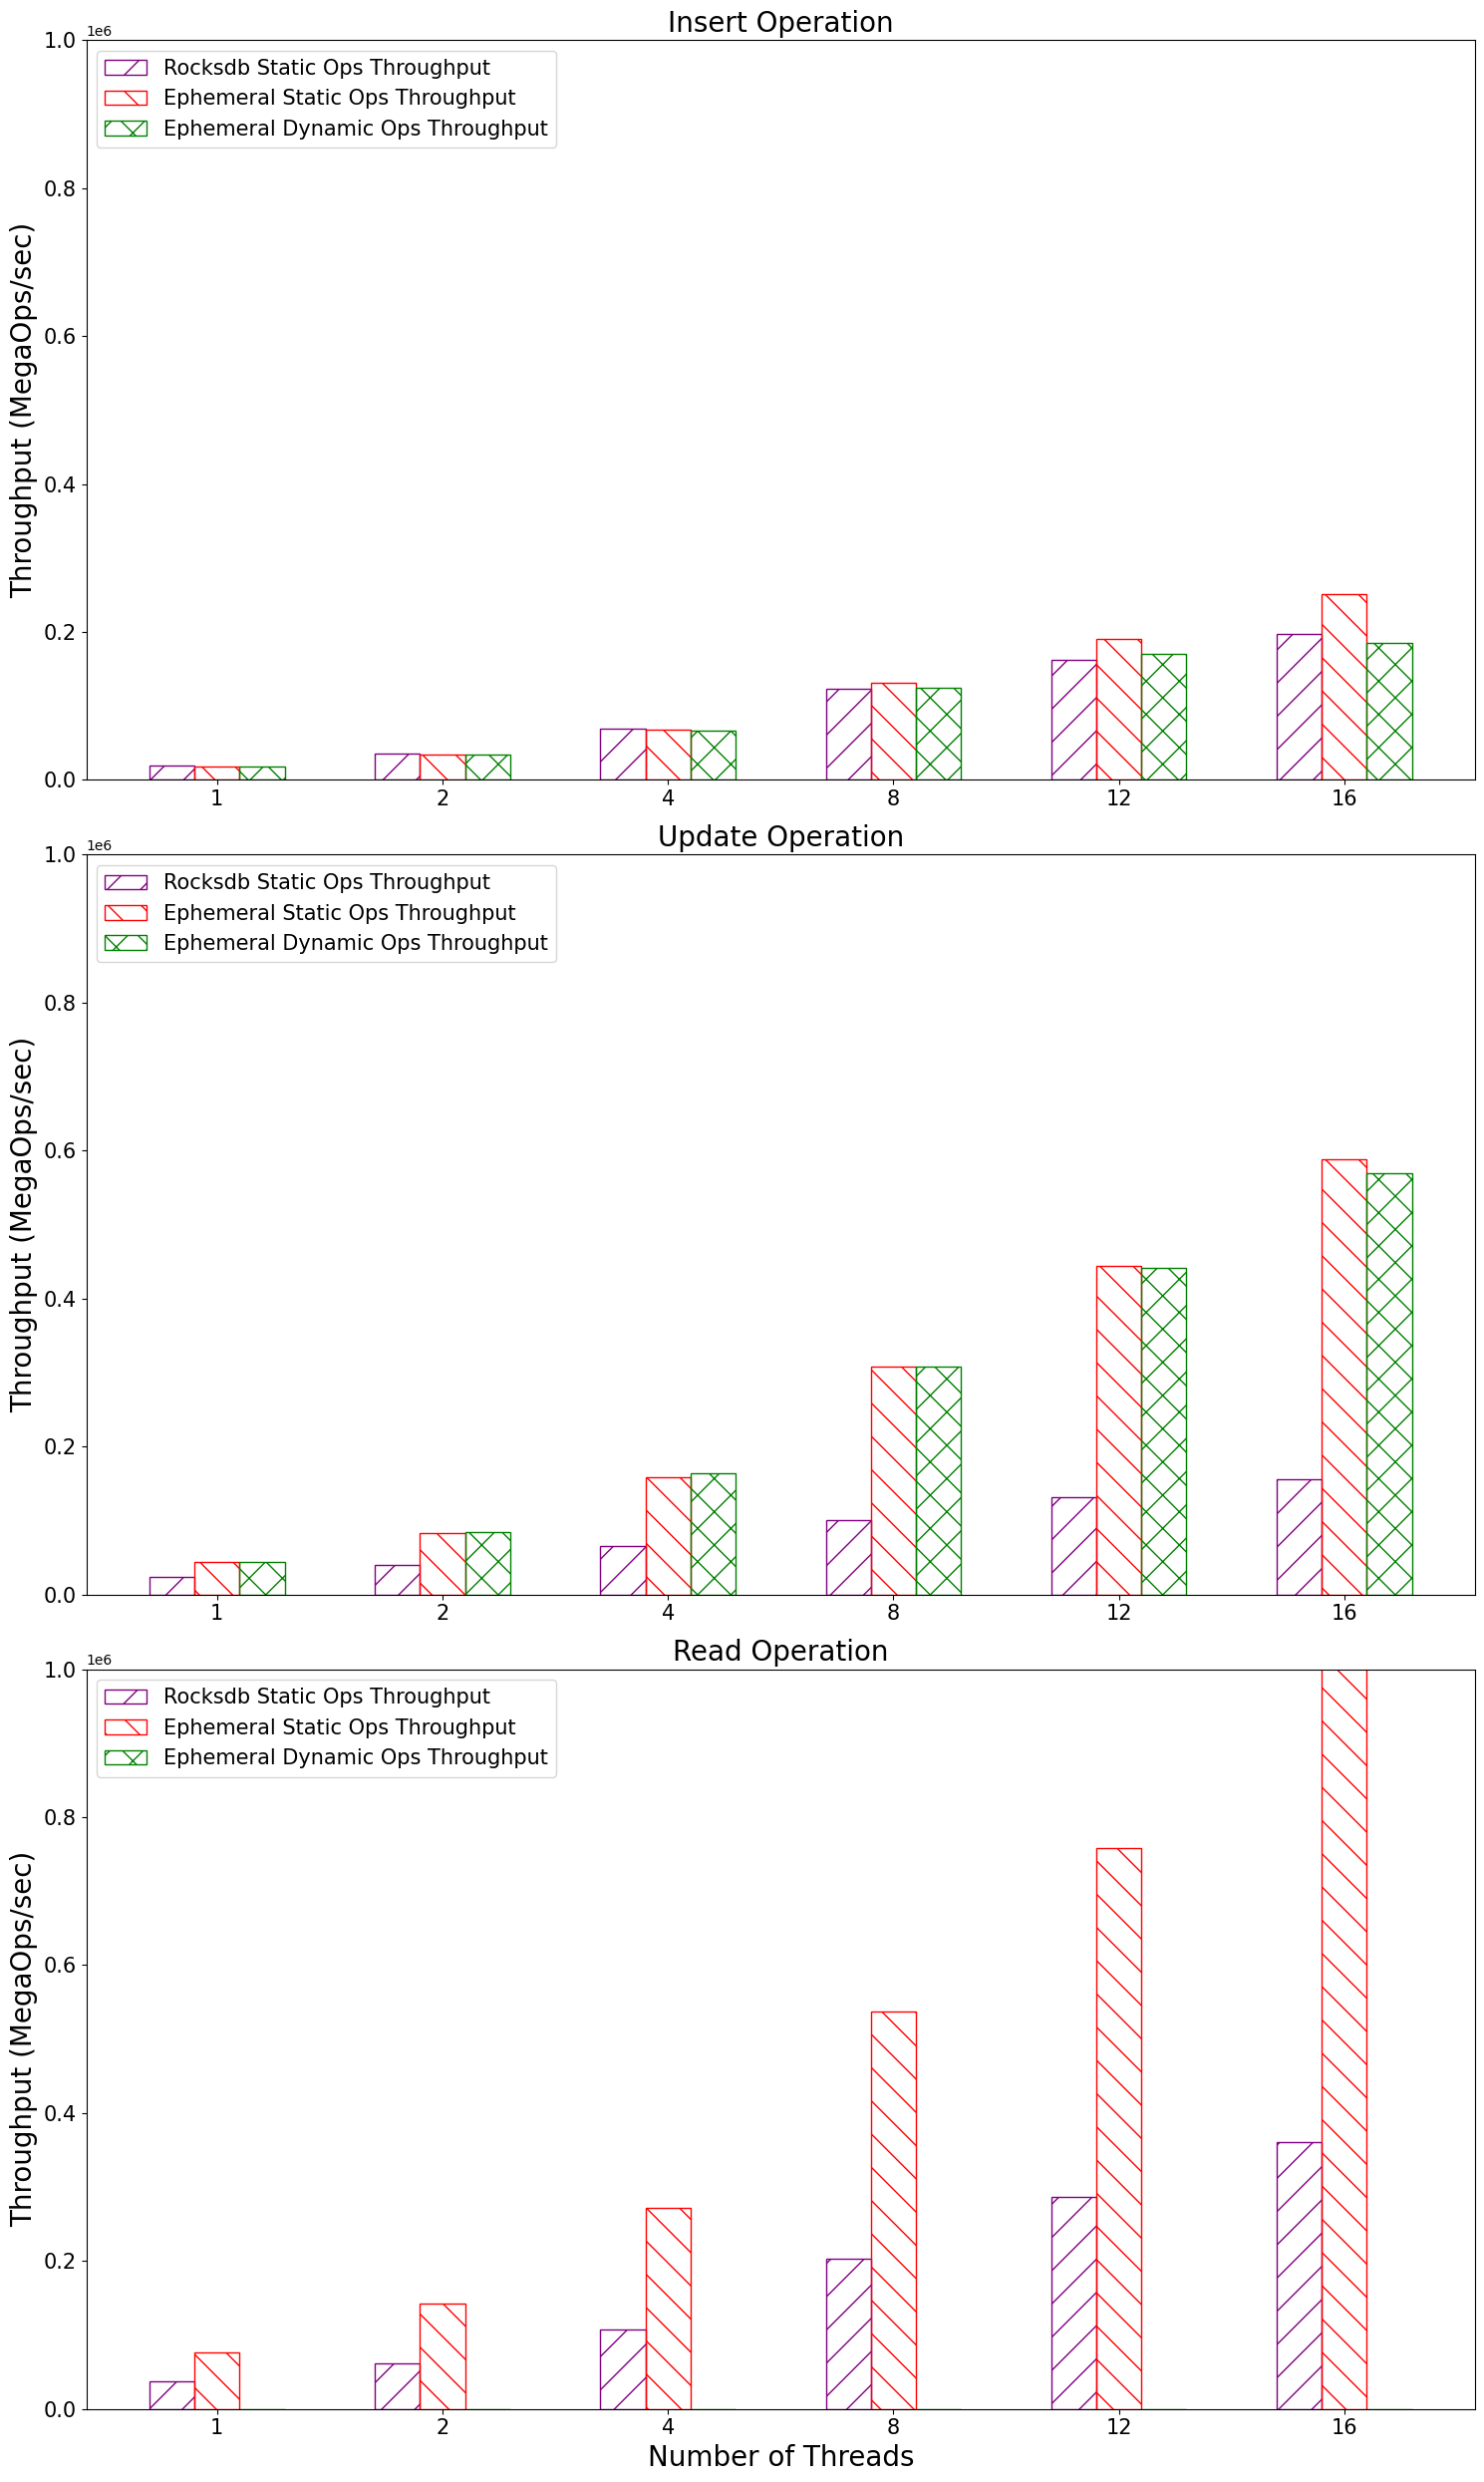

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                throughput = 0.0
                ops_time = 0.0
                if "Running benchmark with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {}

                elif "Running insert Ops." in line:
                    operation = 'insert'

                elif "Running update Ops." in line:
                    operation = 'update'

                elif "Running read Ops." in line:
                    operation = 'read'
                elif "Runtime Init :" in line:
                    pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    match = re.search(pattern, line)
                    if match:
                        ops_time = float(match.group(2))
                        data[current_thread][operation]= 800000 / ops_time
                    
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemral_dynamic_data):
    # def create_stacked_bar_chart(rocksdb_data, persistent_data, ephemeral_data):
    threads = sorted(set(rocksdb_data.keys()) | set(ephemeral_static_data.keys()) | set(ephemeral_dynamic_data.keys()))
    operations = ['insert', 'update', 'read']
    
    x = np.arange(len(threads))
    width = 0.2
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 25))
    
    for i, operation in enumerate(operations):

        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        ephemeral_static_throughput = [ephemeral_static_data[t].get(f'{operation}', 0) for t in threads]
        
        if (operation == 'read'):
            ephemeral_dynamic_throughput = [0 for t in threads]
        else:
            ephemeral_dynamic_throughput = [ephemeral_dynamic_data[t][operation] for t in threads]

        rocksdb_throughput = [rocksdb_data[t][operation] for t in threads]
        
        # ephemeral_throughput = [ephemeral_data[t][operation] for t in threads]
        
        axs[i].bar(x - width, rocksdb_throughput, width, label='Rocksdb Static Ops Throughput', hatch='/', facecolor='none', edgecolor='purple')
        # axs[i].bar(x - width, rocksdb_cleanup, width, bottom=rocksdb_ops, label='RocksDB Cleanup', color='lightblue')
        # axs[i].bar(x - width, rocksdb_init, width, bottom=[sum(x) for x in zip(rocksdb_ops, rocksdb_cleanup)], label='RocksDB Init', color='darkblue')
        
        # axs[i].bar(x, ephemeral_static_throughput, width, label='Ephemeral Static Ops Throughput', hatch='\\')
        axs[i].bar(x, ephemeral_static_throughput, width, label='Ephemeral Static Ops Throughput', hatch='\\', facecolor='none', edgecolor='red')

        axs[i].bar(x + width, ephemeral_dynamic_throughput, width, label='Ephemeral Dynamic Ops Throughput', hatch='x', facecolor='none', edgecolor='green')
        # axs[i].bar(x, persistent_cleanup, width, bottom=persistent_ops, label='Persistent Cleanup', color='lightgreen')
        # axs[i].bar(x, persistent_init, width, bottom=[sum(x) for x in zip(persistent_ops, persistent_cleanup)], label='Persistent Init', color='darkgreen')
        
        
        
        # axs[i].bar(x + width, ephemeral_throughput, width, label='Ephemeral Ops Throughput', color='red')
        # axs[i].bar(x + width, ephemeral_cleanup, width, bottom=ephemeral_ops, label='Ephemeral Cleanup', color='lightcoral')
        # axs[i].bar(x + width, ephemeral_init, width, bottom=[sum(x) for x in zip(ephemeral_ops, ephemeral_cleanup)], label='Ephemeral Init', color='darkred')
        
        # for j, thread in enumerate(threads):
        #     axs[i].text(x[j] - width, rocksdb_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j], persistent_throughput[j], ha='center', va='bottom')
        #     axs[i].text(x[j] + width, ephemeral_throughput[j], ha='center', va='bottom')
        
        axs[i].set_ylabel('Throughput (MegaOps/sec)', fontsize=20)
        axs[i].set_title(f'{operation.capitalize()} Operation', fontsize=20)
        axs[i].tick_params(axis='x', labelsize=15)
        axs[i].tick_params(axis='y', labelsize=15)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        # axs[i].legend()
        axs[i].legend(fontsize=15, loc='upper left')
        # Set y-axis limit to 2e+6
        axs[i].set_ylim(0, 1e+6)
    
    axs[2].set_xlabel('Number of Threads', fontsize=20)
    plt.tight_layout()
    # plt.savefig('../plots/benchmark_results_throughput_static_dynamic_prev_rocksdb_IUR.png')
    # plt.title("RocksDB vs Ephemeral vs Persistent (MultiThreaded - (insert, update, read))")
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/benchmark_rocksdb.txt')
ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/benchmark_ephemeral_dynamic_tail2_IRU.txt')
# ephemeral_data = parse_file('benchmark_ephemeral.txt')
# print("RocksDB : ")
# print(rocksdb_data)
# print("Persistent : ")
# print(persistent_data)
print("Rocksdb : ")
print(rocksdb_data)
print("ephemeral static : ")
print(ephemeral_static_data)
print("Ephemeral Dynamic: ")
print(ephemeral_dynamic_data)


# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_static_data, ephemeral_dynamic_data)


### Benchmarking using custom_benchmark ephemeral dynamic and rocksdb

Rocksdb : 
{1: {'insert': 248524.38645542096, 'update': 241545.89371980677}, 2: {'insert': 193236.71497584542, 'update': 192215.28111484862}, 4: {'insert': 283889.28317956, 'update': 279818.118223155}, 8: {'insert': 446179.5872838818, 'update': 435255.7127312296}, 16: {'insert': 666666.6666666667, 'update': 659521.8466611706}}
Ephemeral Dynamic: 
{1: {'insert': 283587.3803615739, 'update': 442967.8848283499}, 2: {'insert': 487210.71863581, 'update': 800800.8008008008}, 4: {'insert': 842992.6238145416, 'update': 1401050.7880910684}, 8: {'insert': 1428571.4285714284, 'update': 2325581.3953488376}, 16: {'insert': 1526717.5572519084, 'update': 2150537.634408602}}


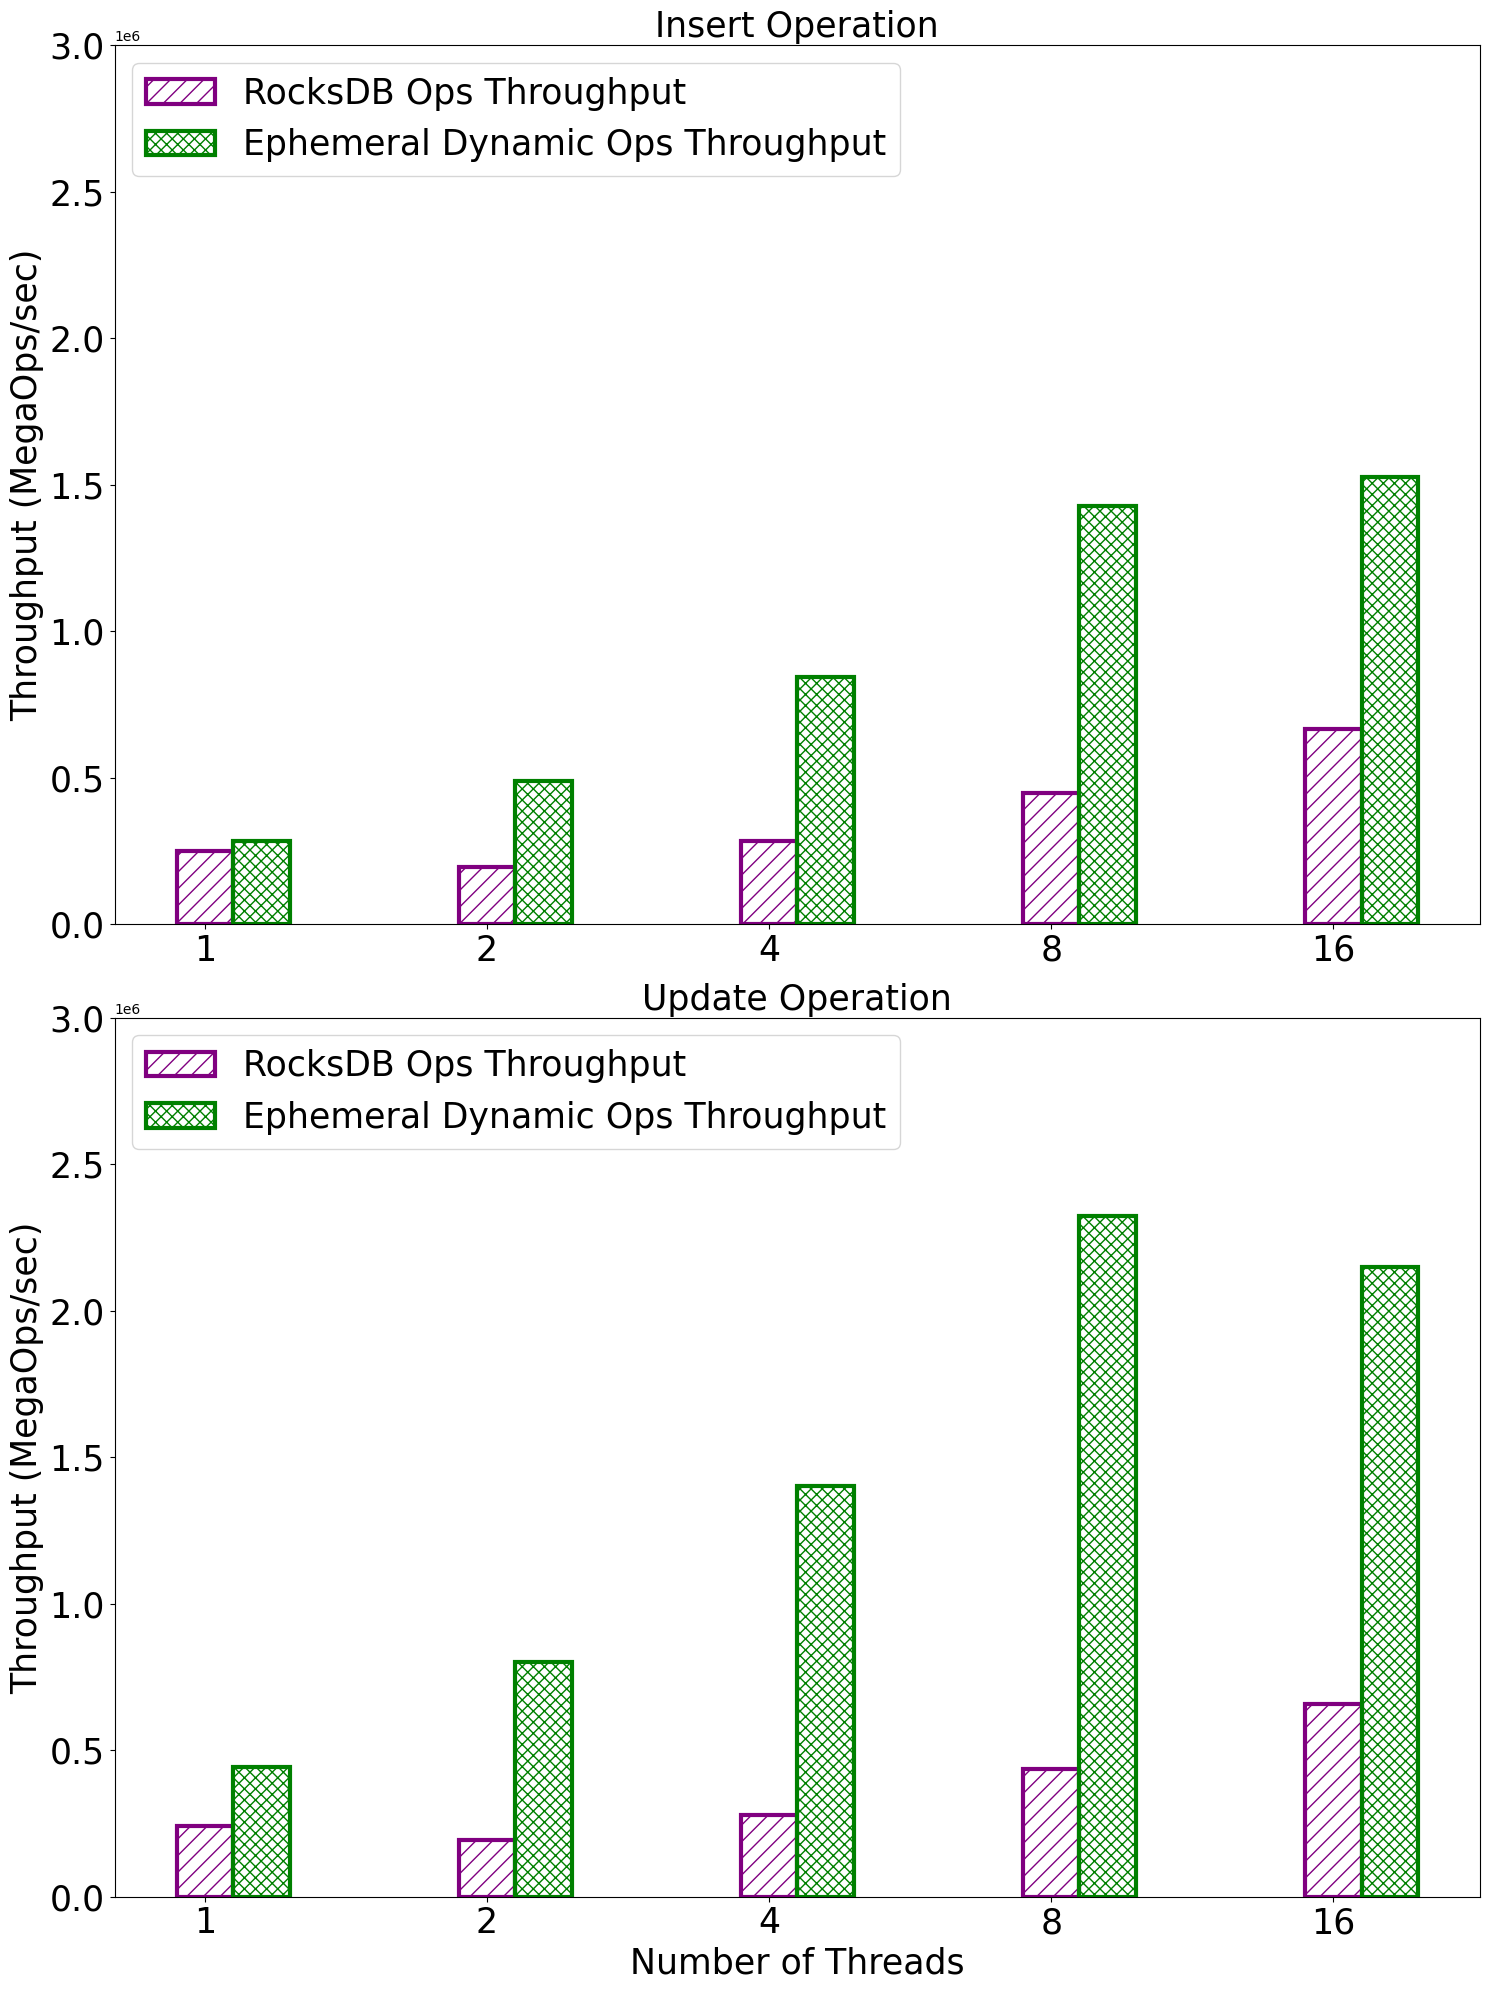

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_file(filename):
    data = {}
    current_thread = None
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            try:
                throughput = 0.0
                ops_time = 0.0
                if "Running with" in line:
                    current_thread = int(re.search(r'(\d+) threads', line).group(1))
                    data[current_thread] = {}

                elif "800000 inserts." in line or "Starting insertion with" in line:
                    operation = 'insert'

                elif "800000 updates." in line or "Starting updates with" in line:
                    operation = 'update'

                elif "completed in" in line:
                    time_in_ms = float(re.search(r'(\d+)ms', line).group(1))
                    ops_time = time_in_ms / 1000
                    data[current_thread][operation]= 800000 / ops_time
                    # pattern = r"Runtime Init : (\S+) Runtime Ops : (\S+) Runtime Cleanup : (\S+) Runtime Total : (\S+)"
                    # match = re.search(pattern, line)
                    # if match:
                    #     ops_time = float(match.group(2))
                    #     data[current_thread][operation]= 800000 / ops_time
                    
            except Exception as e:
                print("Error in line : ", i)
    return data

def create_stacked_bar_chart(rocksdb_data, ephemeral_dynamic_data):
    threads = sorted(set(rocksdb_data.keys()) | set(ephemeral_dynamic_data.keys()))
    operations = ['insert', 'update']
    
    x = np.arange(len(threads))
    width = 0.2
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))
    
    # Define style parameters
    border_width = 3.0
    dense_hatch = '//'
    
    for i, operation in enumerate(operations):
        ephemeral_dynamic_throughput = [ephemeral_dynamic_data[t][operation] for t in threads]
        rocksdb_throughput = [rocksdb_data[t][operation] for t in threads]
        
        # RocksDB bars
        axs[i].bar(x, rocksdb_throughput, width, 
                  label='RocksDB Ops Throughput', 
                  hatch=dense_hatch, 
                  facecolor='none', 
                  edgecolor='purple', 
                  linewidth=border_width)
        
        # Ephemeral Dynamic bars
        axs[i].bar(x + width, ephemeral_dynamic_throughput, width, 
                  label='Ephemeral Dynamic Ops Throughput', 
                  hatch='xxx', 
                  facecolor='none', 
                  edgecolor='green', 
                  linewidth=border_width)
        
        axs[i].set_ylabel('Throughput (MegaOps/sec)', fontsize=25)
        axs[i].set_title(f'{operation.capitalize()} Operation', fontsize=25)
        axs[i].tick_params(axis='x', labelsize=25)
        axs[i].tick_params(axis='y', labelsize=25)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(threads)
        axs[i].legend(fontsize=25, loc='upper left')
        axs[i].set_ylim(0, 3e+6)
    
    axs[1].set_xlabel('Number of Threads', fontsize=25)
    plt.tight_layout()
    plt.show()

# Parse the files
rocksdb_data = parse_file('./throughput_files/custom_throughput_rocksdb.txt')
# ephemeral_static_data = parse_file('./throughput_files/benchmark_ephemeral_static_insert_read.txt')
ephemeral_dynamic_data = parse_file('./throughput_files/custom_throughput_ephemeral_dynamic.txt')
# ephemeral_data = parse_file('benchmark_ephemeral.txt')
# print("RocksDB : ")
# print(rocksdb_data)
# print("Persistent : ")
# print(persistent_data)
print("Rocksdb : ")
print(rocksdb_data)
# print("ephemeral static : ")
# print(ephemeral_static_data)
print("Ephemeral Dynamic: ")
print(ephemeral_dynamic_data)


# Create the stacked bar chart
create_stacked_bar_chart(rocksdb_data, ephemeral_dynamic_data)
